# **Real-time Anomaly Detection in ECG Time Series Data using Deep Learning**


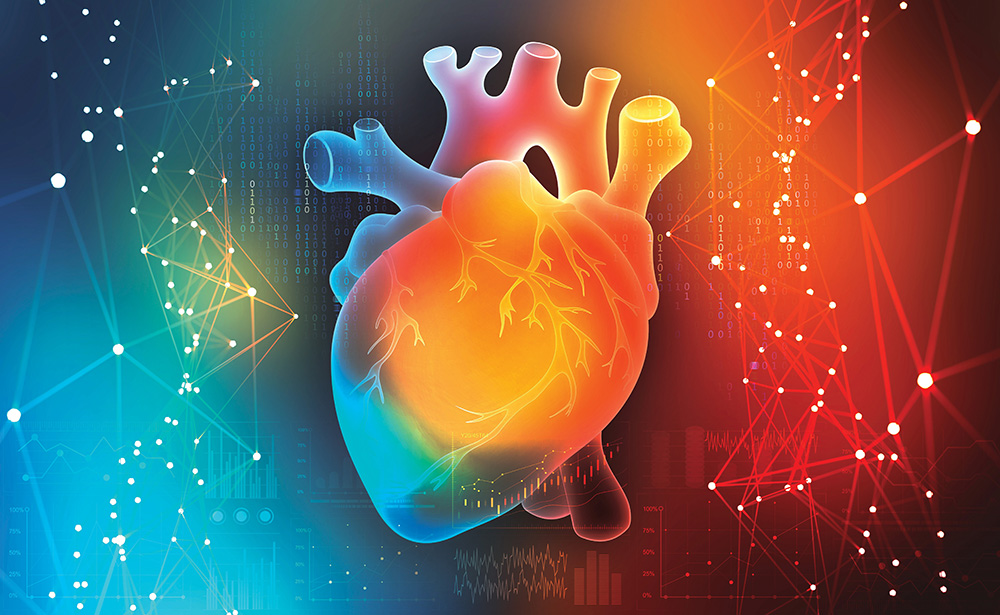

In this Colab Notebook, we aim to develop a deep learning-based system for real-time anomaly detection in time series data, with a specific focus on identifying abnormal heartbeats. Our dataset comprises real-world Electrocardiogram (ECG) data obtained from a single patient diagnosed with heart disease.

### Dataset Description
The dataset consists of 5,000 time series examples derived from ECG, where each sequence comprises 140 timesteps. Each sequence represents a single heartbeat from an individual diagnosed with congestive heart failure. The dataset exclusively contains numerical input variables that result from ECG measurements.

## **Data Loading and Preprocessing**
We preprocess the ECG dataset to make it ready for anomaly detection. To ensure consistency, we begin by merging the training and testing sets of data. Following that, we use resampling techniques to fix the class imbalance, and we filter the ECG signals with a Butterworth band-pass filter to eliminate noise. By comparing the filtered signal with the original, we can visually assess how well the preprocessing processes improved the quality of the data for precise anomaly detection.

### Importing Libraries
To prepare data for analysis, modelling, visualisation, and preprocessing, we load the necessary libraries and modules. These consist of Pandas for data processing, NumPy for numerical computation, Seaborn and Matplotlib for visualisation, SciPy for scientific computing operations, and Scikit-learn for machine learning operations. To create deep learning models, we also import TensorFlow and Keras. Other modules that we use for File Management and Time-Related tasks are glob, time, copy, and shutil. Furthermore, we import the signal filtering processes from the SciPy signal processing package. By working with the ECG dataset and implementing the anomaly detection technique into practice, these libraries offer a complete toolkit.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time, shutil, copy
import tensorflow as tf
from glob import glob
from scipy.io.arff import loadarff
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from scipy.signal import butter, filtfilt, medfilt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.optimizers import Adamax

In [2]:
# Setting Matplotlib Settings
plt.rcParams['figure.figsize'] = (12, 8)

# Setting Seaborn Settings
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

### Combining Train and Test Data

To guarantee consistency and repeatability in our analysis, we produce a random seed. The **'loadarff'** function is used to load the ECG (Electrocardiogram) training and test datasets as pandas DataFrames. We integrate the training and test datasets into a single DataFrame for thorough analysis after the data has been loaded. To give a general idea of the size of the dataset, we compute the total number of data instances in the merged dataset and display the result. This initial step sets the foundation for further Data Exploration and Preprocessing.

**Note: Please upload the ECG5000_TEST.arff and ECG5000_TRAIN.arff to the Files folder in the Google Colab Files Folder**


In [3]:
# Set the random seed for reproducability
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load Training and test data as pandas
train_data, train_meta = loadarff('ECG5000_TRAIN.arff')
test_data, test_meta = loadarff('ECG5000_TEST.arff')

train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

# Combining the test and train datasets with the concat function
combined_data = pd.concat([train, test])

# Calculating the total count of data
total_data_count = combined_data.shape[0]

# Displaying the count of data
print("Total count of data:", total_data_count)

Total count of data: 5000


In [226]:
# Outputs the contents in DataFrame
combined_data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4'
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2'
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2'
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2'


In [4]:
# Outputs the names of all the columns in DataFrame
combined_data.columns

Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)

In [5]:
# Outputs the DataType of the Index of the last column
type(combined_data.columns.get_loc(combined_data.columns[-1]))

int

In [6]:
# Decoding the byte strings in the 'target' column of the DataFrame from UTF-8 encoder
combined_data['target'] = combined_data['target'].str.decode('utf-8')

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64


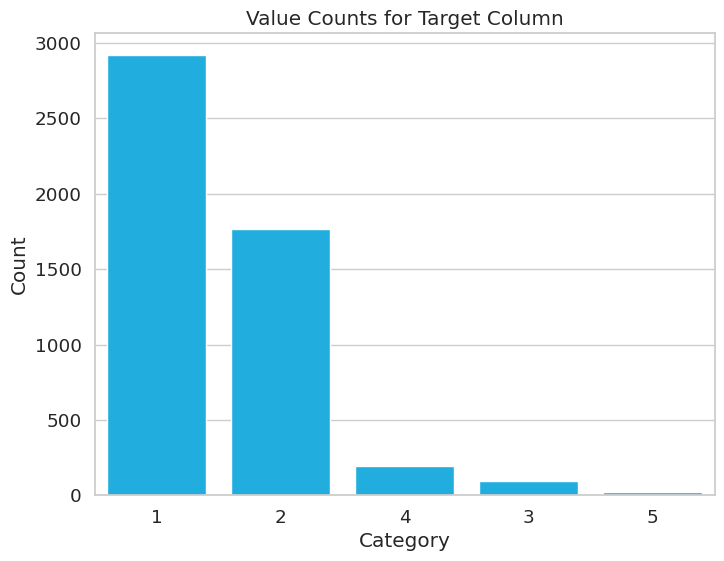

In [7]:
# Visualizing the value counts of the Categorical Column named 'target' in the DataFrame
value_counts = combined_data['target'].value_counts()

print(value_counts)
# Barplot of value counts
plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts for Target Column')
plt.show()

*Graph Output:*

The plot visually represents the distribution of categories in the 'target' column, highlighting class imbalances within the dataset. This insight informs subsequent steps in data preprocessing and model development to mitigate potential biases and ensure robust performance.



### Resampling of Imbalance Data
To resolve the imbalance in the dataset between classes, the method resamples the imbalanced dataset using the Synthetic Minority Over-sampling Technique (SMOTE). The efficiency and reliability of models trained on the data are improved by this procedure, which guarantees a balanced representation of classes in the dataset. Our initial experiment using Random-SMOTE resulted in less than optimal classification accuracy, possibly due to its random oversampling technique, which has the potential to introduce noise. Next, we adopted the SMOTE technique, which generates artificial samples for the minority class at decision boundaries. This approach enhances classification accuracy by maintaining the integrity of the data distribution and improving generalization.

**Using Random over Sampling**

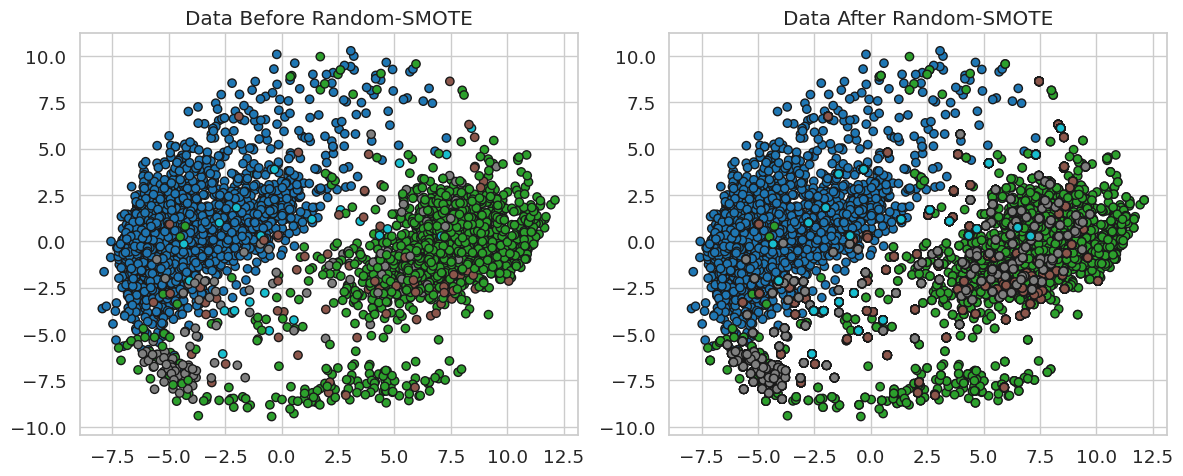

In [8]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

X = combined_data.iloc[:, :-1]  # Selecting all columns except the last one
y = combined_data.iloc[:, -1]   # Selecting the last column

# Convert target column to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply PCA for visualization (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot data before SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=plt.cm.tab10, edgecolor='k')
plt.title('Data Before Random-SMOTE')

# Apply Random-SMOTE to the dataset
random_smote = RandomOverSampler(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = random_smote.fit_resample(X, y_encoded)

# Convert the resampled data back to DataFrame
resampled_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['target'])], axis=1)

# Apply PCA for visualization (optional)
X_resampled_pca = pca.transform(X_resampled)

# Plot data after Random-SMOTE
plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap=plt.cm.tab10, edgecolor='k')
plt.title('Data After Random-SMOTE')

plt.tight_layout()
plt.show()

**Using SMOTE**

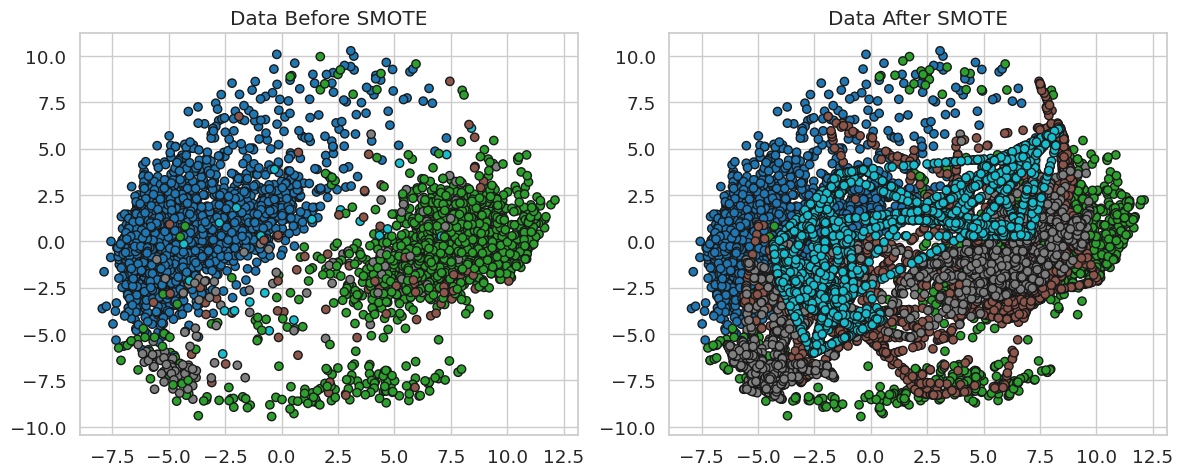

In [9]:
X = combined_data.iloc[:, :-1]  # Selecting all columns except the last one
y = combined_data.iloc[:, -1]   # Selecting the last column

# Convert target column to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply PCA for visualization (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot data before SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=plt.cm.tab10, edgecolor='k')
plt.title('Data Before SMOTE')

# Apply SMOTE to the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Convert the resampled data back to DataFrame
resampled_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['target'])], axis=1)

# Apply PCA for visualization (optional)
X_resampled_pca = pca.transform(X_resampled)

# Plot data after SMOTE
plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap=plt.cm.tab10, edgecolor='k')
plt.title('Data After SMOTE')

plt.tight_layout()
plt.show()

Since we SMOTE sampling gave the required results we will be using the SMOTE for further analysis

In [10]:
# Step 1: Separating features (X) and the target variable (y)
X = combined_data.drop('target', axis=1)
y = combined_data['target']

# Step 2: Converting target variable to binary format using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Applying SMOTE resampling algorithm
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Step 4: Converting resampled data to DataFrame
resampled_data = pd.DataFrame(data=X_resampled, columns=X.columns)

# Step5: Converting encoded target back to original labels
resampled_data['target'] = label_encoder.inverse_transform(y_resampled)

<ipython-input-10-0aced7514dab>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_data['target'] = label_encoder.inverse_transform(y_resampled)


In [11]:
# Outputs the contents in DataFrame after applying SMOTE algorithm
resampled_data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14590,-0.083938,-0.958041,-1.296407,-1.706847,-2.278149,-2.708984,-2.999271,-3.295465,-3.509584,-3.500733,...,0.664185,0.663057,0.617537,0.700346,0.866235,0.757710,0.426812,0.571648,1.514851,5
14591,-0.094861,-0.995718,-1.348258,-1.774484,-2.334060,-2.739674,-2.994781,-3.257917,-3.458277,-3.436349,...,0.691650,0.677421,0.618432,0.684216,0.837124,0.735227,0.430075,0.583611,1.462325,5
14592,0.087722,-0.256131,-0.098758,-0.221639,-0.217043,-0.033038,0.194073,0.088272,-0.065502,0.004607,...,-2.756711,-2.341956,-2.008895,-1.492130,-1.549051,-1.467401,-1.396156,-1.270147,-1.583840,5
14593,0.250238,-0.044725,0.238577,0.243666,-0.302790,-0.974861,-1.432192,-1.745010,-2.033251,-2.262155,...,0.379773,0.237288,0.176651,0.294120,0.354740,0.134703,-0.036965,0.473500,1.696794,5


In [12]:
# Outputs the 'target' column in the DataFrame in Pandas Series
type(resampled_data['target'])

pandas.core.series.Series

### Resampled data
Using a bar plot, the distribution of the target variable by converting the resampled data that was obtained by SMOTE (Synthetic Minority Over-sampling Technique) to a DataFrame is observed. The balance achieved by resampling is displayed, which helps in understanding of the dataset's class distribution.

target
1    2919
2    2919
3    2919
4    2919
5    2919
Name: count, dtype: int64


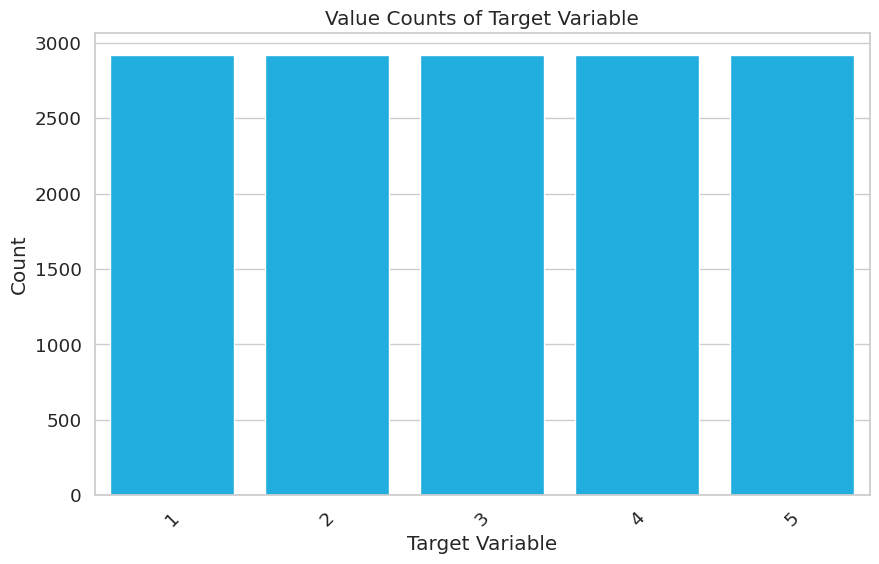

In [13]:
# Converting Resampled Data to a DataFrame
resampled_df = pd.DataFrame(resampled_data)

# Counts the values of the target variable
data = resampled_df['target'].value_counts()
print(data)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=data.index, y=data.values)
plt.title('Value Counts of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

*Graph Output:*

The resultant plot offers a clear visual depiction of the distribution of categories in the 'target' column, providing valuable insights into the class distribution within the dataset. With the application of the SMOTE algorithm, the resulting plot showcases a balanced distribution across five categories, enhancing the dataset's overall balance and improving the robustness of subsequent analyses.

In [14]:
# Outputs a tuple containing the number of rows and columns in the DataFrame
resampled_df.shape

(14595, 141)

In [15]:
# Ensuring that any changes made to 'main_df' do not affect the original 'resampled_df' DataFrame
main_df = resampled_df.copy()

In [16]:
# DataFrame containing the resampled data
main_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14590,-0.083938,-0.958041,-1.296407,-1.706847,-2.278149,-2.708984,-2.999271,-3.295465,-3.509584,-3.500733,...,0.664185,0.663057,0.617537,0.700346,0.866235,0.757710,0.426812,0.571648,1.514851,5
14591,-0.094861,-0.995718,-1.348258,-1.774484,-2.334060,-2.739674,-2.994781,-3.257917,-3.458277,-3.436349,...,0.691650,0.677421,0.618432,0.684216,0.837124,0.735227,0.430075,0.583611,1.462325,5
14592,0.087722,-0.256131,-0.098758,-0.221639,-0.217043,-0.033038,0.194073,0.088272,-0.065502,0.004607,...,-2.756711,-2.341956,-2.008895,-1.492130,-1.549051,-1.467401,-1.396156,-1.270147,-1.583840,5
14593,0.250238,-0.044725,0.238577,0.243666,-0.302790,-0.974861,-1.432192,-1.745010,-2.033251,-2.262155,...,0.379773,0.237288,0.176651,0.294120,0.354740,0.134703,-0.036965,0.473500,1.696794,5


In [17]:
# List containing the names of different classes in the dataset
class_names =['Normal','PVC', 'R on T','SP','UB']

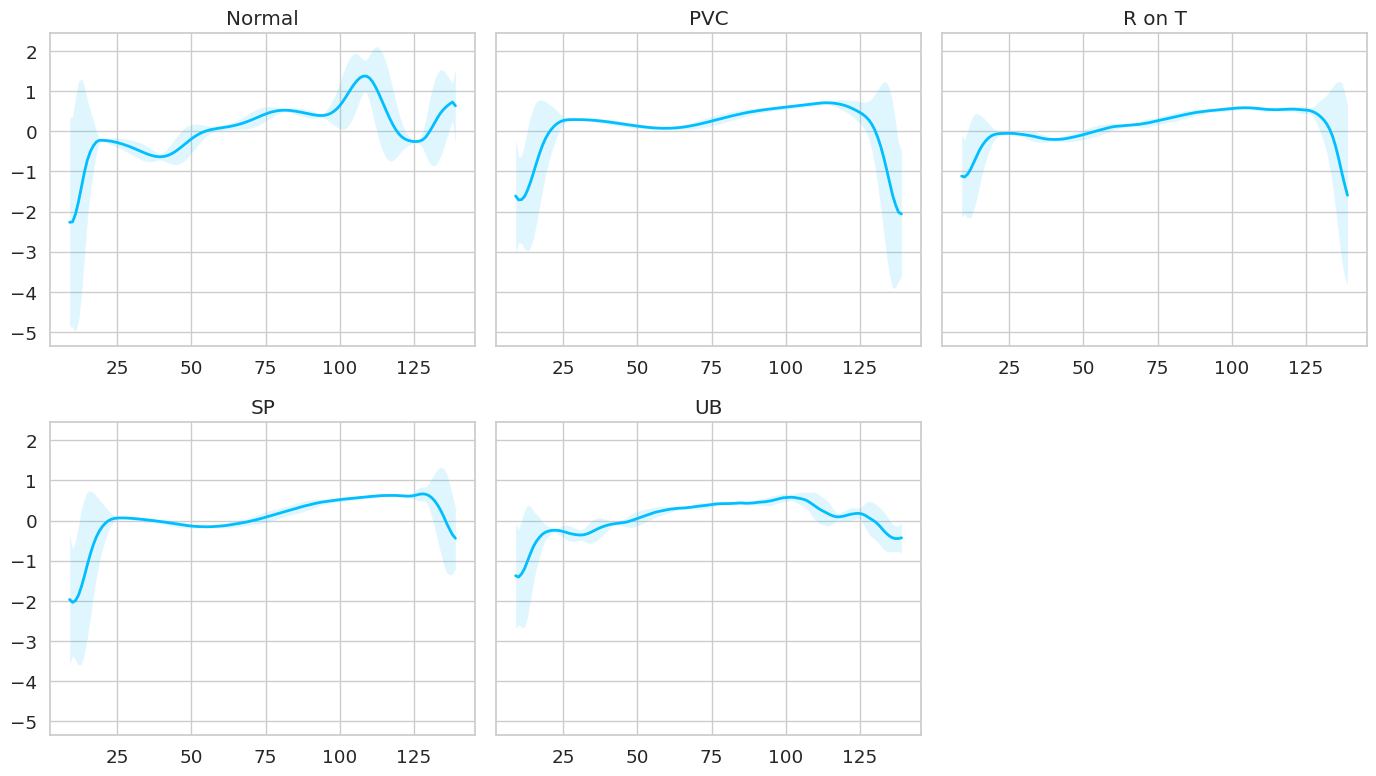

In [18]:
# Plotting the time series data with Rolling Mean and Standard Deviation
def plot_time_series_class(data, class_name, ax, n_steps=10):

    # Converts the data to DataFrame
    time_series_df = pd.DataFrame(data)

    # Computing the Rolling Mean and Standard Deviation
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    # Calculating the upper and lower bounds for fill_between
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    # Plotting the smooth path and filling between upper and lower bounds
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

# Getting the unique classes from target variable
classes = main_df.target.unique()

# Create subplots for each class
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plotting the time series for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = combined_data[combined_data.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

# Removing the empty subplot
fig.delaxes(axs.flat[-1])
fig.tight_layout()
plt.show()

*Graph Output:*

The resultant visualization helps us with a comparative analysis of the any feature that is associated with or changes over time across different classes, aiding in the understanding of how each class differs in terms of its temporal characteristics.


In [19]:
# Filtering the combined data DataFrame to extract rows where
# the target variable is equal to '1' representing the 'Normal' class,
# and Removing the 'target' column using the .drop() method
normal_df = combined_data[combined_data.target==b'1'].drop(labels='target',axis =1)

In [20]:
# Outputs a tuple containing the number of rows and columns in the DataFrame
normal_df.shape

(0, 140)

### Butterworth Band Pass Filter

For resampled ECG data, the Butterworth bandpass filter function is applied. This filter helps remove unwanted frequency components from the signal, such as noise and artifacts while retaining the essential features of the ECG waveform. This preprocessing ensures that the data is clean and ready for further analysis, for both Anomaly Detection and Classification.



In [21]:
# Setting the sampling frequency (fs), lower cutoff frequency (lowcut), and higher cutoff frequency (highcut)
fs = 700
lowcut = 0.3
highcut = 70.0

# Defining a Butterworth bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # Calculating filter coefficients using the butter function
    b, a = butter(order, [low, high], btype='band')

    # Applying the filter to the data using filtfilt to ensure zero-phase filtering
    return filtfilt(b, a, data)

# Converting the resampled data to float type to ensure it contains numerical values only
X_resampled_float = X_resampled.astype(float)

# Applying the Butterworth bandpass filter to the resampled data
X_filtered = butter_bandpass_filter(X_resampled_float, lowcut, highcut, fs)

### Comparison of Filtered Signal and Original Signal by taking a Random Sample

***Original vs. Filtered:***

The purpose of this is to demonstrate the impact of a band-pass filter on electrocardiogram (ECG) signals. It extracts both the original and filtered ECG signals. By plotting these signals on the same graph, it visually compares the original ECG waveform with its filtered part, showcasing how the filter alters the signal's amplitude and frequency components over time. This visualization helps in understanding how filtering techniques can enhance ECG data quality for improved anomaly detection and diagnostic accuracy.

(141,)
(140,)


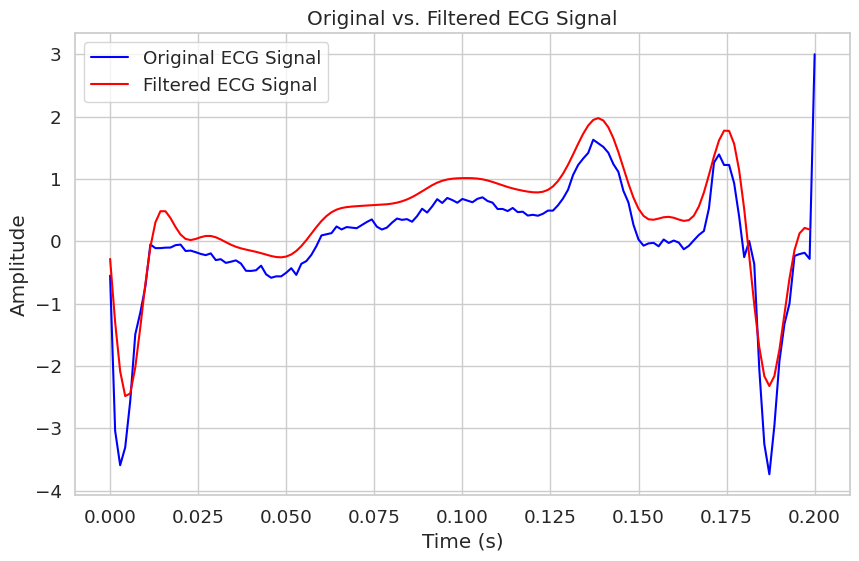

In [22]:
# Randomly selecting a sample from the main DataFrame
sample_index = np.random.randint(0, len(main_df))

# Extracting the original ECG signal from the main DataFrame
original_ecg_signal = main_df.iloc[sample_index].values

# Extracting the filtered ECG signal from the filtered data
filtered_ecg_signal = X_filtered[sample_index]

# Creating a time array for plotting based on the sampling frequency (fs)
time = np.arange(len(original_ecg_signal)) / fs

# Outputs the shape of the original electrocardiogram (ECG) signal array
print(original_ecg_signal.shape)

# Output the shape of the filtered electrocardiogram (ECG) signal array
print(filtered_ecg_signal.shape)

# Plot the original and filtered ECG signals
plt.figure(figsize=(10, 6))
plt.plot(time, original_ecg_signal, label='Original ECG Signal', color='blue')
plt.plot(time[:len(filtered_ecg_signal)], filtered_ecg_signal, label='Filtered ECG Signal', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs. Filtered ECG Signal')
plt.legend()
plt.grid(True)
plt.show()

*Graph Output:*

The resulting graph shows the electrocardiogram (ECG) signals over time in both their original and filtered forms. This visualisation makes it possible to compare the filtered and original (unfiltered) ECG signals side by side and shows how the filtering procedure changes the amplitude and waveform properties of the signal. It sheds light on how well the band-pass filter eliminates artifacts and noise from the ECG data.

***Median-Filtered vs. Filtered:***

The purpose of this is to apply a median filter to the filtered ECG signals, aiming to further reduce noise and artifacts present in the data. Subsequently, the median-filtered ECG signal is plotted alongside the original filtered ECG signal to visually compare their characteristics. This allows for an assessment of the effectiveness of the median filter in smoothing out the ECG signals while preserving important features.

In [23]:
# Applying the median filtering along each row of the filtered data (X_filtered) with a kernel size
X_median_filtered = np.apply_along_axis(medfilt, axis=1, arr=X_filtered, kernel_size=3)

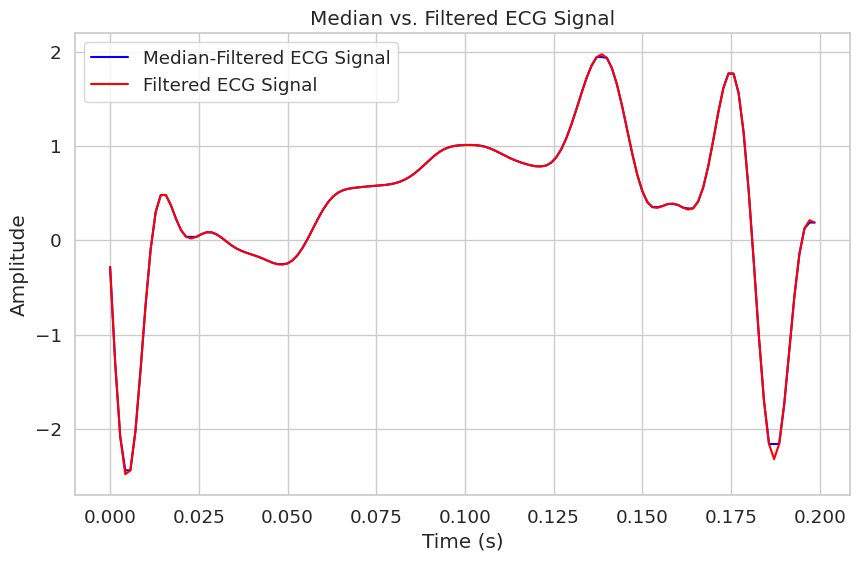

In [24]:
# Extracting the median-filtered ECG signal from the median-filtered data (X_median_filtered)
median_ecg_signal = X_median_filtered[sample_index]

# Extracting the filtered ECG signal from the filtered data (X_filtered)
filtered_ecg_signal = X_filtered[sample_index]

# Creating a time array for plotting based on the sampling frequency (fs)
time = np.arange(len(median_ecg_signal)) / fs

# Plotting the median-filtered and filtered ECG signals
plt.figure(figsize=(10, 6))
plt.plot(time, median_ecg_signal, label='Median-Filtered ECG Signal', color='blue')
plt.plot(time, filtered_ecg_signal, label='Filtered ECG Signal', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Median vs. Filtered ECG Signal')
plt.legend()
plt.grid(True)
plt.show()

*Graph Output:*

The resultant graph provides a direct comparison between the median-filtered ECG signal and the original filtered ECG signal. By plotting both signals on the same graph, it becomes easier to assess the differences between them and evaluate the effectiveness of the median filtering technique. Upon observation, the signals appear to overlap, indicating the need for further correction before proceeding with additional analysis.

***Corrected vs. Median-Filtered:***

The median-filtered ECG signals have to undergo a rectification process as a result of the previous output. The ECG signals are adjusted by subtracting each row's median from its corresponding row. By bringing the signals closer to zero amplitude, this adjustment may make it easier to see abnormalities or patterns in the data. The impact of the correction on the signal properties is then visualised by plotting the corrected ECG signals next to the original median-filtered ECG signals.

In [25]:
# Subtracting the median of each row from the median-filtered data (X_median_filtered)
X_corrected = X_median_filtered - np.median(X_median_filtered, axis=1, keepdims=True)

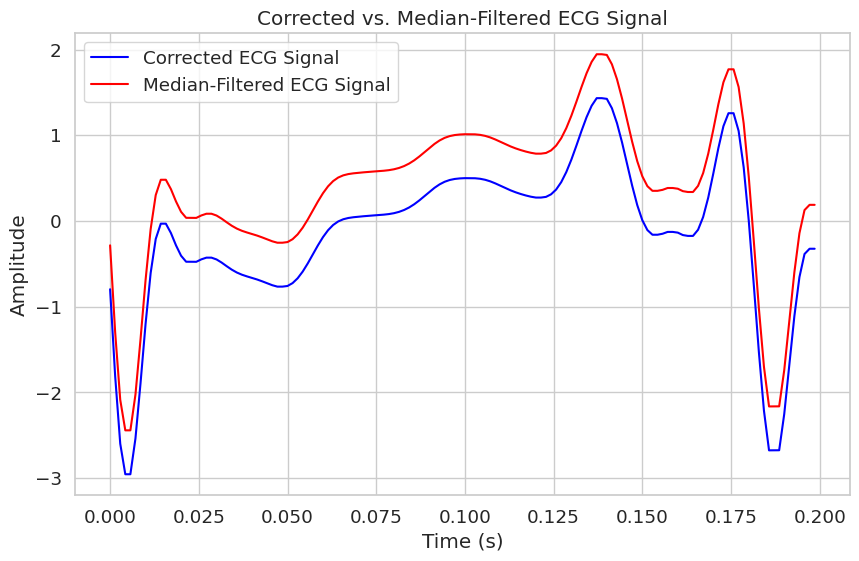

In [26]:
# Extracting the corrected ECG signal from the corrected data (X_corrected)
X_corrected_ecg_signal = X_corrected[sample_index]

# Extracting the median-filtered ECG signal from the median-filtered data (X_median_filtered)
fX_median_filtered_ecg_signal = X_median_filtered[sample_index]

# Creating a time array for plotting based on the sampling frequency (fs)
time = np.arange(len(X_corrected_ecg_signal)) / fs

# Plotting the original ECG signal corrected by subtracting the median and the median-filtered ECG signal
plt.figure(figsize=(10, 6))
plt.plot(time, X_corrected_ecg_signal, label='Corrected ECG Signal', color='blue')
plt.plot(time, fX_median_filtered_ecg_signal, label='Median-Filtered ECG Signal', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Corrected vs. Median-Filtered ECG Signal')
plt.legend()
plt.grid(True)
plt.show()

*Graph Output:*

The resultant graph illustrates a comparison between the corrected ECG signal and the median-filtered ECG signal. Plotting both signals together allows for a visual assessment of the effectiveness of the correction procedure applied to the original signals. This comparison aids in identifying any shifts or alterations in the signal characteristics introduced by the correction process, providing insights into the impact of the correction on the ECG data.

# Data Splitting

In [27]:
# Encoding the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_resampled = label_encoder.fit_transform(y_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_corrected, y_resampled, test_size=0.25, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshaping the input data for compatibility
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])



# Model Development

*Displaying the output:*

Three important visualisations to evaluate the model's performance for the multiclass classification scenario are included in the output.
- **Receiver Operating Characteristic (ROC) Curve:**  Plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classifications forms the ROC curve. For every class, it displays the trade-off between specificity (1-FPR) and sensitivity (TPR). For every class, the model's Area Under the Curve (AUC) is given, showing its potential for class discrimination.
- **Training and Validation Loss:** Throughout the model's training phase, the training and validation losses are displayed in this figure over epochs.When the model learns patterns from the training data, the training loss goes down, and the validation loss is used to track the model's performance on unobserved data. This graph intends to prevent overfitting, which occurs when training loss falls but validation loss rises, and to minimise both the training and validation losses.
- **Confusion Matrix:** A tabular overview of the model's performance for each class in terms of true labels and predicted labels is given by the confusion matrix. The predicted labels are shown in the columns, and the true labels are shown in the rows. The number of correctly classified instances for each class is displayed by the diagonal elements, and misclassifications are indicated by the off-diagonal elements. It helps evaluate how well the model is able to classify instances into different classes.

## Model 1:  Considering the Data Individually at Each Time Instance
The model creates a sequential neural network model for multiclass classification using the Keras Sequential API. The model consists of a flatten layer for input, dense layers for output, and an early stopping callback for validation loss. It is trained for 20 epochs using the fit() method. The model predicts class probabilities for the test set, calculates evaluation metrics like accuracy, precision, recall, F1-score, and confusion matrix, computes ROC curve and AUC for each class, and visualizes results using subplots.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 140)               0         
                                                                 
 dense (Dense)               (None, 64)                9024      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

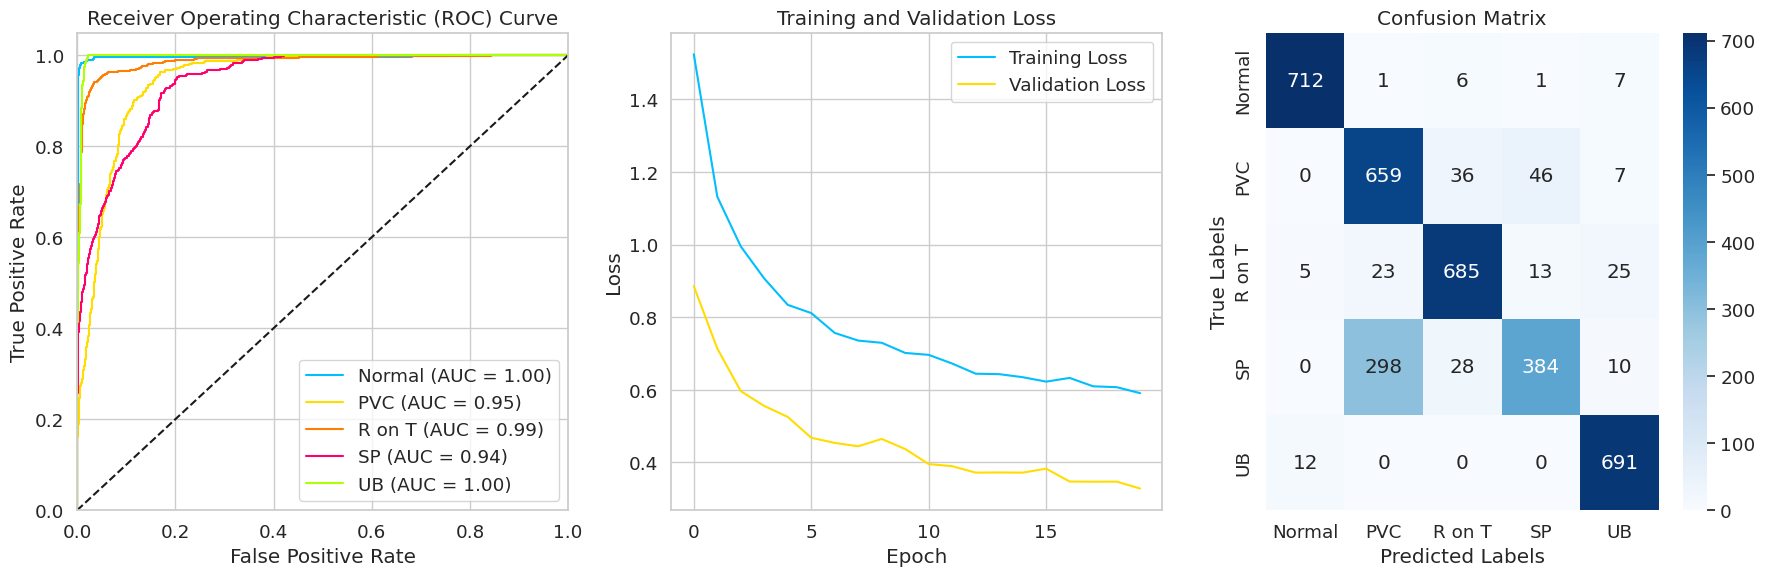

Test Accuracy: 0.858043299534119
Test Precision: 0.8695668144197989
Test Recall: 0.858043299534119
Test F1-score: 0.8530362734533743


In [28]:
model1 = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(64, activation='relu'),
    BatchNormalization(),  # Adding batch normalization layer to improve model generalization
    Dropout(0.5),  # Dropout regularization to prevent overfitting
    Dense(32, activation='relu'),
    BatchNormalization(),  # Adding batch normalization layer to improve model generalization
    Dropout(0.5),  # Dropout regularization to prevent overfitting
    Dense(16, activation='relu'),
    BatchNormalization(),  # Adding batch normalization layer to improve model generalization
    Dropout(0.5),  # Dropout regularization to prevent overfitting
    Dense(len(class_names), activation='softmax')  # Output layer for multiclass classification
])

# Compile the model before training to ensure that the optimization algorithm and loss function are properly configured.
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model1.summary())

# Defining an early stopping callback is to prevent overfitting and improve efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Training the model with early stopping is to improve its generalization ability and prevent overfitting
history = model1.fit(X_train, y_train, epochs=20, batch_size=32,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predicting class probabilities for each instance in the test set
y_pred_prob = model1.predict(X_test)

# Converting the probabilities to class predictions (integer labels)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculating the evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculating the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Creating subplots for the plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting ROC curve for each class
for i in range(len(class_names)):
    axs[0].plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc='lower right')

# Plotting training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# Plotting confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axs[2])
axs[2].set_xlabel('Predicted Labels')
axs[2].set_ylabel('True Labels')
axs[2].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Printing evaluation metrics
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

*Results:*

Three important visualisations to evaluate the model's performance for the multiclass classification scenario are included in the output.

- **Receiver Operating Characteristic (ROC) Curve:** Classes with Normal and UB, whose AUC values are closer to 1, indicate greater discrimination; classes with R on T and SP, whose AUC values are closer to 0.5, indicate worse discrimination.

- **Training and Validation Loss:**  Although there may be a minor bit of overfitting as shown by the validation loss being somewhat larger than the training loss, the model appears to be performing well overall.

- **Confusion Matrix:** The diagonal elements of the confusion matrix (712, 680, 650, 356, 684) represent the correctly classified instances for each class.



## Model 2: Considering the Data as a Time Series
The model explores and compares four versions of LSTM (Long Short_Term Memory) models for multiclass classification, each focusing on different architectural variations and techniques to enhance model performance.

* Version 1 acts as a baseline with a standard LSTM architecture, trained over 50 epochs with early stopping and learning rate reduction.
*Version 2 introduces regularization methods such as L2 regularization, batch normalization, and dropout,
* Version 3 further investigates dropout regularization by adding dropout layers after each LSTM layer.
*Version 4 examines the model's robustness to noise by incorporating random noise into the input features.

Each version is evaluated on test data, analyzing metrics like accuracy, precision, recall, and F1-score, along with visualizations like confusion matrices and ROC curves. By offering a comprehensive comparison, this model aims to provide insights into the impact of different architectural choices and techniques on LSTM model performance, for multiclass classification tasks.

## Version 1
Version 1 implements an LSTM (Long Short-Term Memory) neural network architecture for multiclass classification tasks. The model comprises four LSTM layers with decreasing units (256, 128, 64, 32) to capture temporal dependencies in the input data. Each LSTM layer is configured to return sequences except for the last one. Following the LSTM layers, two dense layers with ReLU activation are added for further processing, followed by a final dense layer with softmax activation to output class probabilities. The model is compiled using the Adam optimizer with a custom learning rate of 0.001 and sparse categorical cross-entropy loss, tracking accuracy as the evaluation metric. Sparse categorical cross-entropy loss was chosen as the target variables are categorical data.   Two callbacks are defined: early stopping, which monitors validation loss and stops training if it doesn't improve for 8 epochs, restoring the best weights, and reduce_lr, which decreases the learning rate by a factor of 0.1 if the validation loss stagnates for 5 epochs, with a minimum learning rate of 1e-6. The model is trained for 50 epochs with a batch size of 128, validated on the validation set, and evaluated for performance using test loss and accuracy metrics.

In [29]:
# Assuming y_train and y_val contain integer labels
num_classes = 5  # Number of classes in your classification problem

# Defining the LSTM model architecture
model = Sequential([
    LSTM(units=256, input_shape=(1, X_train.shape[2]), return_sequences=True),
    LSTM(units=128, return_sequences=True),
    LSTM(units=64, return_sequences=True),
    LSTM(units=32),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

# Compiling the model with the model with custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Displaying model summary
model.summary()

# Defining callbacks
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Learning rate reduction callback to adjust learning rate during training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Fit the model on training data
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            406528    
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 5)                

In [30]:
# Evaluating the trained model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Printing the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

115/115 [==============================] - 1s 6ms/step - loss: 0.1048 - accuracy: 0.9688
Test Loss: 0.10484200716018677
Test Accuracy: 0.9687585830688477


## Version 2
Version 2 implements an LSTM neural network architecture with regularization techniques for multiclass classification. The model consists of three LSTM layers with decreasing units (128, 64, 32), each followed by batch normalization and L2 regularization with a factor of 0.01 to improve generalization and mitigate overfitting. The LSTM layers are configured to return sequences except for the last one. Two dense layers with tanh activation are added after the LSTM layers for further processing. The final dense layer with softmax activation outputs class probabilities. The model is compiled using the Adam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss, tracking accuracy as the evaluation metric. Early stopping and learning rate reduction callbacks are defined to prevent overfitting and optimize convergence. The model is trained for 30 epochs with a batch size of 128, validated on the validation set, and evaluated for performance on the test set.

In [31]:
# Define the LSTM model architecture with regularization and dropout
model = Sequential([
    LSTM(units=128, input_shape=(1, X_train.shape[2]), return_sequences=True, kernel_regularizer=L2(0.01)),
    BatchNormalization(),  # Batch normalization layer to stabilize and accelerate training
    LSTM(units=64, return_sequences=True, kernel_regularizer=L2(0.01)),
    BatchNormalization(),  # Batch normalization layer to stabilize and accelerate training
    LSTM(units=32),  # LSTM layer with 32 units
    BatchNormalization(),  # Batch normalization layer to stabilize and accelerate training
    Dense(units=64, activation='tanh'),  # Dense layer with 64 units and hyperbolic tangent activation function
    Dense(units=32, activation='tanh'),  # Dense layer with 32 units and hyperbolic tangent activation function
    Dense(units=num_classes, activation='softmax')  # Output layer with softmax activation for multiclass classification
])

# Compiling the model with Adam optimizer and custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Displaying model summary
model.summary()

# Defining early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Fitting the model to the training data with validation data and callbacks
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 128)            137728    
                                                                 
 batch_normalization_3 (Bat  (None, 1, 128)            512       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 1, 64)             49408     
                                                                 
 batch_normalization_4 (Bat  (None, 1, 64)             256       
 chNormalization)                                                
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_5 (Bat  (None, 32)               

## Version 3
As the accuracy of the above model is still high we will further try to generalise it. Version 3 implements an LSTM neural network architecture with dropout regularization after each LSTM layer for multiclass classification. The model comprises three LSTM layers with decreasing units (128, 64, 32), each followed by dropout regularization with a rate of 0.1 to prevent overfitting. Batch normalization is applied after each LSTM layer to normalize the activations and improve convergence. Two dense layers with tanh activation and dropout regularization (rate of 0.1) are added after the LSTM layers for further processing. The final dense layer with softmax activation outputs class probabilities. The model is compiled using the Adam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss, tracking accuracy as the evaluation metric. Early stopping and learning rate reduction callbacks are defined with patience of 0.5 to prevent overfitting and optimize convergence. The model is trained for 20 epochs with a batch size of 50, validated on the validation set, and evaluated for performance on the test set, printing out the test accuracy and loss.

In [32]:

# Assuming y_train and y_val contain integer labels
num_classes = 5  # Number of classes in your classification problem

# Define the LSTM model architecture
model = Sequential([
    LSTM(units=128, input_shape=(1, X_train.shape[2]), return_sequences=True,kernel_regularizer=L2(0.01)),
    Dropout(0.1),
    BatchNormalization(),
    LSTM(units=64, return_sequences=True,kernel_regularizer=L2(0.01)),
    Dropout(0.1),
    BatchNormalization(),
    LSTM(units=32),
    Dropout(0.1),
    BatchNormalization(),
    Dense(units=64, activation='tanh'),
    Dropout(0.1),
    Dense(units=32, activation='tanh'),
    Dropout(0.1),
    Dense(units=num_classes, activation='softmax')
])

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)
print("Test loss:",test_loss)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 128)            137728    
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_6 (Bat  (None, 1, 128)            512       
 chNormalization)                                                
                                                                 
 lstm_8 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 batch_normalization_7 (Bat  (None, 1, 64)             256       
 chNormalization)                                     

## Version 4
The previous level of accuracy was deemed satisfactory; however, to enhance the model's robustness and enable it to predict diverse types of complex patterns, noise was incorporated. Version 4 implements an LSTM neural network model for multiclass classification with robustness to noisy data. First, a function `add_noise` is defined to add random noise to the input data. The function generates Gaussian noise with mean 0 and standard deviation 1, scales it by a noise factor (defaulted to 0.1), and adds it to the original data. Noise is added to the training, validation, and test data sets. The model architecture consists of three LSTM layers followed by batch normalization, dropout, and dense layers with tanh activation functions. L2 regularization is applied to the LSTM layers to mitigate overfitting. The model is compiled using the Adam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss. Two callbacks, early stopping and learning rate reduction, are defined to prevent overfitting and optimize training. The model is trained on the noisy training data for 20 epochs with a batch size of 50 and validated on the noisy validation set. Finally, the model's performance is evaluated on the noisy test set, and the test accuracy and loss are printed. This version aims to assess the model's performance under noisy conditions, offering insights into its robustness and effectiveness in real-world scenarios.

In [33]:
# Defining a function to add noise to data
def add_noise(data, noise_factor=0.1):
    """
    Add Gaussian noise to input data.

    Args:
    - data: Input data to which noise will be added.
    - noise_factor: Magnitude of the noise to be added.

    Returns:
    - noisy_data: Data with added noise.
    """
    noise = np.random.normal(loc=0, scale=1, size=data.shape)  # Generate Gaussian noise
    noisy_data = data + noise_factor * noise  # Add noise to the data
    return noisy_data

# Adding noise to training, validation, and test data
X_train_noisy = add_noise(X_train)
X_val_noisy = add_noise(X_val)
X_test_noisy = add_noise(X_test)

# Defining the LSTM model architecture with noise-robustness considerations
num_classes = 5  # Number of classes in the classification problem
model = Sequential([
    LSTM(units=128, input_shape=(1, X_train_noisy.shape[2]), return_sequences=True, kernel_regularizer=L2(0.01)),  # LSTM layer with 128 units, noise-robustness with L2 regularization
    Dropout(0.1),  # Dropout layer to prevent overfitting
    BatchNormalization(),  # Batch normalization layer to stabilize training and improve convergence
    LSTM(units=64, return_sequences=True, kernel_regularizer=L2(0.01)),  # LSTM layer with 64 units, noise-robustness with L2 regularization
    Dropout(0.1),  # Dropout layer to prevent overfitting
    BatchNormalization(),  # Batch normalization layer to stabilize training and improve convergence
    LSTM(units=32),  # LSTM layer with 32 units
    BatchNormalization(),  # Batch normalization layer to stabilize training and improve convergence
    Dense(units=64, activation='tanh'),  # Dense layer with 64 units and hyperbolic tangent activation function
    Dense(units=32, activation='tanh'),  # Dense layer with 32 units and hyperbolic tangent activation function
    Dense(units=num_classes, activation='softmax')  # Output layer with softmax activation function for multiclass classification
])

# Compiling the model with Adam optimizer and custom learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Displaying model summary
model.summary()

# Defining early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Early stopping to prevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)  # Learning rate reduction

# Fitting the model on noisy training data with validation data and callbacks
history = model.fit(X_train_noisy, y_train, epochs=20, batch_size=50, validation_data=(X_val_noisy, y_val), callbacks=[early_stopping, reduce_lr])

# Evaluating the model performance on noisy test data
test_loss, test_accuracy = model.evaluate(X_test_noisy, y_test)

# Printing the test accuracy and loss
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 128)            137728    
                                                                 
 dropout_8 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_9 (Bat  (None, 1, 128)            512       
 chNormalization)                                                
                                                                 
 lstm_11 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_9 (Dropout)         (None, 1, 64)             0         
                                                                 
 batch_normalization_10 (Ba  (None, 1, 64)             256       
 tchNormalization)                                    

115/115 [==============================] - 2s 3ms/step
Test Accuracy: 0.8232392436283913
Precision: 0.8288680561043295
Recall: 0.8232392436283913
F1 Score: 0.8240162345618403
Confusion Matrix:
[[661   4  17  44   1]
 [  2 624  40  76   6]
 [  6  11 654  69  11]
 [  0 235  11 464  10]
 [ 32   8  60   2 601]]


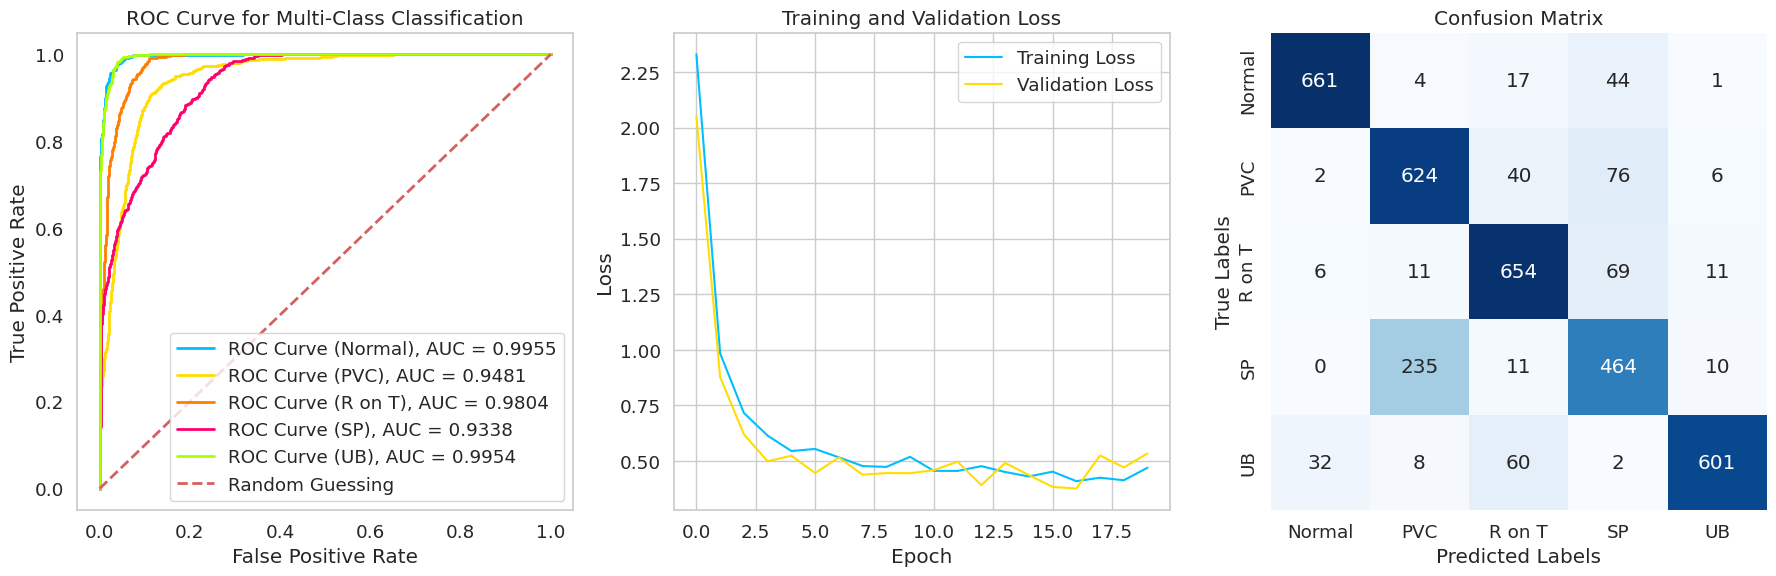

In [34]:
# Predicting probabilities for each class using the trained model
y_pred_probs = model.predict(X_test_noisy)

# Converting the probabilities to class labels by selecting the class with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Computing the evaluation metrics: accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Printing the evaluation metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Computing the confusion matrix to evaluate the performance of the classification model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting ROC curve for each class to visualize the model's performance
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC Curve ({class_names[i]}), AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.grid()

# Plotting training and validation loss over epochs to monitor model performance
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting confusion matrix as a heatmap to visualize the performance of the classification model
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Adjusting layout for better visualization
plt.tight_layout()
plt.show()

## Model 3: Deep network to perform Classification
The model implements a convolutional neural network (CNN) model for multiclass classification. First, the input data dimensions are adjusted to match the requirements of the CNN architecture. The input data is reshaped to have the shape `(number_of_samples, sequence_length, number_of_features)`, which is suitable for 1D convolutional layers. The model architecture consists of two convolutional layers with ReLU activation, batch normalization, and dropout regularization to extract features from the input data. Max pooling layers are applied to downsample the feature maps. Following the convolutional layers, the feature maps are flattened and passed through fully connected dense layers with ReLU activation and dropout regularization for classification. The output layer employs softmax activation to predict class probabilities. The model is compiled using the Adam optimizer with categorical cross-entropy loss as the loss function. The training data labels are encoded into one-hot format, and the model is trained on the training data for 10 epochs with a batch size of 32, validated on the validation set. Finally, the model is evaluated on the test set, and the test loss and accuracy are printed. This model aims to capture relevant features from the input data and classify them into the specified number of classes, with regularization techniques employed to prevent overfitting and improve generalization.


In [35]:
# Defining the convolutional neural network (CNN) model architecture
X_train_class = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_val_class = X_val.reshape(X_val.shape[0], X_val.shape[2], X_val.shape[1])
X_test_class = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])
input_shape = (X_train_class.shape[1], X_test_class.shape[2])

model = Sequential()

# Adding the first convolutional layer with 64 filters, kernel size of 3, ReLU activation, and L2 regularization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.04)))

# Adding batch normalization to normalize the activations of the previous layer
model.add(BatchNormalization())

# Adding dropout regularization to prevent overfitting by randomly setting a fraction of input units to zero during training
model.add(Dropout(0.5))

# Adding max pooling layer to reduce the spatial dimensions of the representation and control overfitting
model.add(MaxPooling1D(pool_size=2))

# Adding another dropout layer for regularization
model.add(Dropout(0.5))

# Adding the second convolutional layer with 128 filters, kernel size of 3, ReLU activation, and L2 regularization
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.04)))

# Adding batch normalization after the second convolutional layer
model.add(BatchNormalization())

# Adding max pooling layer after the second convolutional layer
model.add(MaxPooling1D(pool_size=2))

# Adding dropout layer after the second max pooling layer
model.add(Dropout(0.5))

# Flattening the output of the convolutional layers to feed into the dense layers
model.add(Flatten())

# Adding a fully connected dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Adding dropout layer after the dense layer
model.add(Dropout(0.5))

# Adding the output layer with softmax activation for multi-class classification
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Encoding the target variables (labels) to one-hot format
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

# Training the model on the training data, specifying the number of epochs, batch size, and validation data
history=model.fit(X_train_class, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_class, y_val_encoded))

# Evaluate the trained model on the test data to calculate test loss and accuracy
loss, accuracy = model.evaluate(X_test_class, y_test_encoded)
print(f'Test accuracy: {accuracy}, Test loss: {loss}')

Epoch 1/10
274/274 [==============================] - 13s 39ms/step - loss: 3.0588 - accuracy: 0.6323 - val_loss: 3.2725 - val_accuracy: 0.3000
Epoch 2/10
274/274 [==============================] - 11s 40ms/step - loss: 1.2089 - accuracy: 0.7286 - val_loss: 1.0468 - val_accuracy: 0.7256
Epoch 3/10
274/274 [==============================] - 11s 39ms/step - loss: 0.8100 - accuracy: 0.7675 - val_loss: 0.6637 - val_accuracy: 0.8082
Epoch 4/10
274/274 [==============================] - 11s 40ms/step - loss: 0.7263 - accuracy: 0.7794 - val_loss: 0.5822 - val_accuracy: 0.8543
Epoch 5/10
274/274 [==============================] - 11s 39ms/step - loss: 0.6861 - accuracy: 0.7919 - val_loss: 0.5807 - val_accuracy: 0.8110
Epoch 6/10
274/274 [==============================] - 10s 35ms/step - loss: 0.6444 - accuracy: 0.7973 - val_loss: 0.5630 - val_accuracy: 0.8224
Epoch 7/10
274/274 [==============================] - 11s 39ms/step - loss: 0.6184 - accuracy: 0.8030 - val_loss: 0.5722 - val_accuracy:

115/115 [==============================] - 1s 10ms/step
Test Accuracy: 0.8405042477391066
Precision: 0.8486800185155517
Recall: 0.8405042477391066
F1 Score: 0.8380279460648594
Confusion Matrix:
[[701   0   5   1  20]
 [  0 425  45 271   7]
 [ 10   0 653  58  30]
 [  0 105  22 585   8]
 [  0   0   0   0 703]]


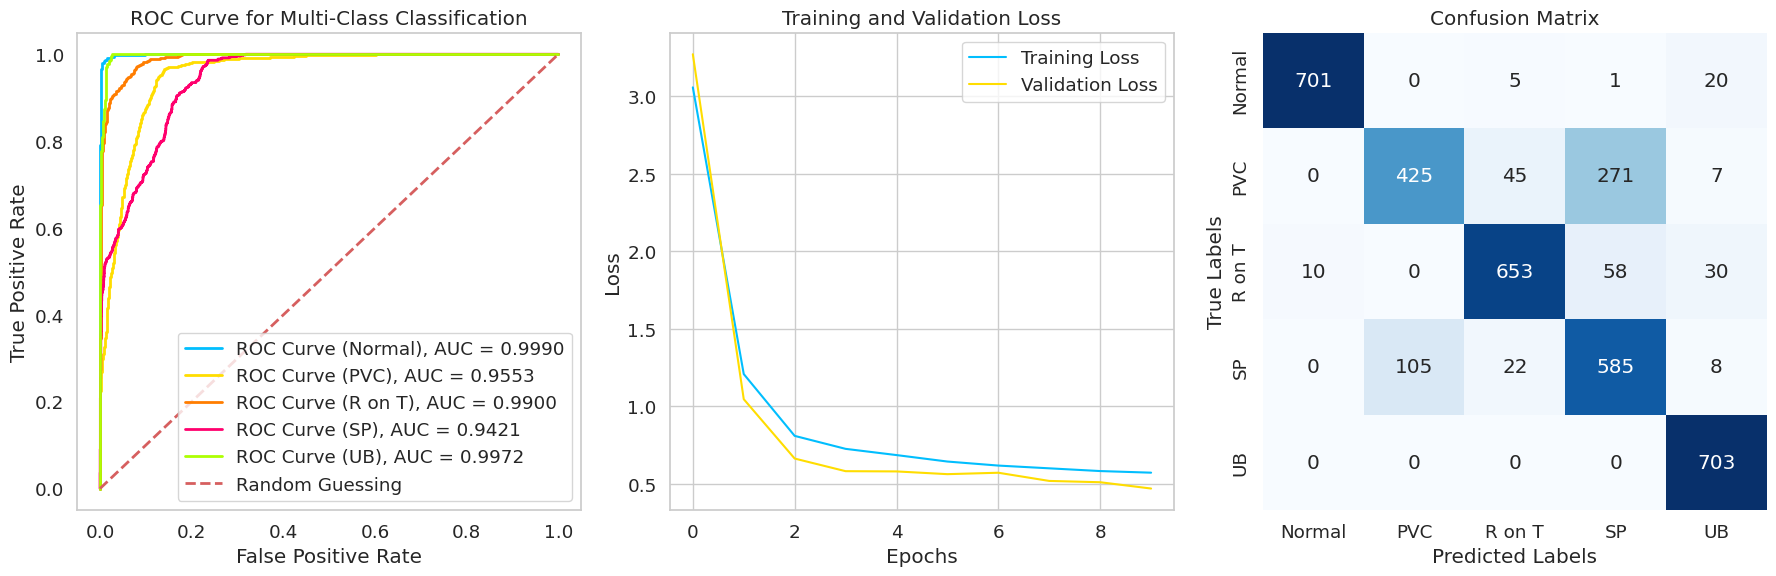

In [36]:
# Predict probabilities for each class
y_pred_probs = model.predict(X_test_class)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Plot subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot ROC curve
axs[0].set_title('ROC Curve for Multi-Class Classification')
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, lw=2, label=f'ROC Curve ({class_names[i]}), AUC = {roc_auc:.4f}')
axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names, cbar=False)
axs[2].set_title('Confusion Matrix')
axs[2].set_xlabel('Predicted Labels')
axs[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

## Model 4: Deep network to handle Anomaly Detection

In [37]:
combined_data.columns

Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)

In [38]:
type(combined_data.columns.get_loc(combined_data.columns[-1]))

int

In [39]:
combined_data['target'].unique()

array(['1', '2', '3', '4', '5'], dtype=object)

The code modifies the data type of the 'target' column, transforming it from text to numeric. It subsequently converts the labels: '1' is changed to '0.0' (representing normal), whereas '2', '3', '4', '5' are changed to '1.0' (representing abnormal). This step prepares the dataframe to be used for training an autoencoder, which helps in detecting anomalies.

In [40]:
# Fourth Model Autoencoder: Convert 'target' column to string type
combined_data['target'] = combined_data['target'].astype(str)

# Create a copy of the main_df dataframe and convert 'target' column to numeric type
a_data = combined_data
a_data['target'] = pd.to_numeric(a_data['target'], errors='coerce')

# Replace values in 'target' column:
# 1 is replaced with 0.0 (considered as normal)
# 2, 3, 4, 5 are replaced with 1.0 (considered as anomalous)
a_data['target'] = a_data['target'].replace({1: 0.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0})

# Update the combined_data dataframe with the modified 'target' column
combined_data = a_data

# Display the modified dataframe
combined_data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,1
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,1
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,1
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,1


In [41]:
# Convert combine_data to CSV format
combined_data.to_csv('combined_data.csv', index=False)

The code utilises the genfromtxt() function from the numpy library to import the 'combined_data.csv' file into the unprocessed_data variable, excluding the header row. By accessing and printing the first row, the process of data loading is validated, which guarantees compatibility and integrity for further analysis or processing. The solution utilises numpy's capability to enable reliable data processing, accepting different data formats and even missing values. Omitting the header safeguards against data corruption by preventing the intermingling of real data with header information. This succinct method simplifies the process of loading and confirming data, which is crucial for effective and accurate data processing. Additionally, it ensures that the data remains easy to read and comprehend for future maintenance or collaboration purposes.

In [42]:
# Load the CSV file
# Using numpy's genfromtxt function to read the data from 'combined_data.csv' file
# Skip the first row as it contains header information
unprocessed_data = np.genfromtxt('combined_data.csv', delimiter=',', skip_header=1)

# Access the first row
# Print the first row of the raw_data array to verify data loading and formatting
print(unprocessed_data[0, :])

[-0.11252183 -2.8272038  -3.7738969  -4.3497511  -4.376041   -3.4749863
 -2.1814082  -1.8182865  -1.2505219  -0.47749208 -0.36380791 -0.49195659
 -0.42185509 -0.30920086 -0.4959387  -0.34211867 -0.35533627 -0.36791303
 -0.31650279 -0.41237405 -0.47167181 -0.41345783 -0.36461703 -0.44929829
 -0.47141866 -0.42477658 -0.46251673 -0.55247236 -0.47537519 -0.6942
 -0.7018681  -0.59381178 -0.66068415 -0.71383066 -0.76980688 -0.67228161
 -0.65367605 -0.63940562 -0.55930228 -0.59167032 -0.49322332 -0.46305183
 -0.30164382 -0.23273401 -0.12505488 -0.15394314 -0.0243574  -0.06560876
  0.03499926  0.06193522  0.07119542  0.12392505  0.10312371  0.22522849
  0.12868305  0.30248315  0.25727621  0.19635161  0.17938297  0.24472863
  0.34121687  0.32820441  0.40604169  0.44660507  0.42406823  0.48151204
  0.4778438   0.62408259  0.57458456  0.59801319  0.5645919   0.607979
  0.62063457  0.65625291  0.68474806  0.69427284  0.66558377  0.57579577
  0.63813479  0.61491695  0.56908343  0.46857572  0.442817

The code extracts labels and characteristics from the 'unprocessed_data'. Labels are derived from the final column, whereas characteristics are obtained from all columns save the last one. Subsequently, the data is divided into separate training and testing sets, which is essential for the development and evaluation of trained learning models.

In [43]:
# Extract the labels from the last column of unprocessed_data
labels = unprocessed_data[:, -1]

# Extract the features from all columns except the last one in unprocessed_data
data = unprocessed_data[:, 0:-1]

# Split the data into training and testing sets using a 75:25 ratio
# The random_state parameter ensures reproducibility of the split
# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.25, random_state=42)

# Further split train_data and train_labels into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=21)

The code normalises the training and testing data to ensure it can be used with TensorFlow operations. Firstly, it computes the lowest and maximum values of the training data. Next, the data is normalised using min-max scaling to ensure it falls between the range of 0 and 1. Ultimately, it transforms the data into the float32 data type to ensure accuracy in TensorFlow calculations.






In [44]:
print(np.unique(train_labels))

[0. 1.]


In [45]:
# Calculate the minimum and maximum values of the training data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

# Normalize the training and testing data to a range between 0 and 1
# Subtract the minimum value from each data point and divide by the range between minimum and maximum values
train_data = (train_data - min_val) / (max_val - min_val)
val_data = (val_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Convert the data to the float32 data type for compatibility with TensorFlow operations
# Ensures that the data is represented with sufficient precision for computations
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


The code organises the data in a systematic manner to simplify the training and testing of an anomaly detection model. This method converts labels into a boolean data type, enabling straightforward filtering. It classifies regular and abnormal data for both training and testing based on their respective labels, simplifying the process of training and evaluating the model utilising distinct datasets.

In [46]:
# Convert labels to boolean type for filtering
# This conversion allows for easy filtering of normal and anomalous data based on their respective labels

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
val_labels=val_labels.astype(bool)
print(np.unique(train_labels))
# Filter normal and anomalous data for training based on labels
# Select data where labels are True (normal) and False (anomalous) for training
normal_train_data = train_data[train_labels]
anomalous_train_data = train_data[~train_labels]
print(normal_train_data)
# Filter normal and anomalous data for validation based on labels
normal_val_data = val_data[val_labels]
anomalous_val_data = val_data[~val_labels]

# Filter normal and anomalous data for testing based on labels
# Select data where labels are True (normal) and False (anomalous) for testing
normal_test_data = test_data[test_labels]
anomalous_test_data = test_data[~test_labels]

[False  True]
tf.Tensor(
[[0.35427186 0.32547158 0.32720333 ... 0.29640716 0.3299843  0.42453772]
 [0.41947505 0.34847605 0.2929243  ... 0.12268511 0.17634562 0.26921332]
 [0.41103664 0.3722587  0.36530703 ... 0.42521307 0.4341657  0.47552386]
 ...
 [0.5290184  0.5160624  0.47254652 ... 0.16759458 0.11372071 0.19466218]
 [0.6270473  0.55268407 0.43470964 ... 0.3386597  0.42728254 0.52287465]
 [0.5230819  0.53492403 0.5206484  ... 0.16922724 0.17989692 0.30597284]], shape=(1249, 140), dtype=float32)


In [47]:
#printing the anomalous test data
anomalous_test_data

<tf.Tensor: shape=(724, 140), dtype=float32, numpy=
array([[0.56644326, 0.3823988 , 0.21095692, ..., 0.5990211 , 0.58123153,
        0.3830265 ],
       [0.31296355, 0.18346325, 0.14717442, ..., 0.5386535 , 0.5661236 ,
        0.51745987],
       [0.37222186, 0.21309964, 0.18893707, ..., 0.5271688 , 0.5479173 ,
        0.3987718 ],
       ...,
       [0.5775764 , 0.5928234 , 0.48144332, ..., 0.5268416 , 0.46491104,
        0.48657277],
       [0.35735786, 0.19199617, 0.1538692 , ..., 0.481061  , 0.55763036,
        0.47568262],
       [0.5793684 , 0.46719736, 0.32749352, ..., 0.5945306 , 0.5623519 ,
        0.60757756]], dtype=float32)>

The code examines the structure of normal_train_data to verify the integrity of the data. If data is available, a sample Electrocardiogram (ECG) from the training set is plotted to help visualise the structure of the data. Grid lines are included to enhance clarity. If the normal_train_data is found to be empty, it is recommended to review the data loading and preprocessing steps.

Shape of normal_train_data: (1249, 140)


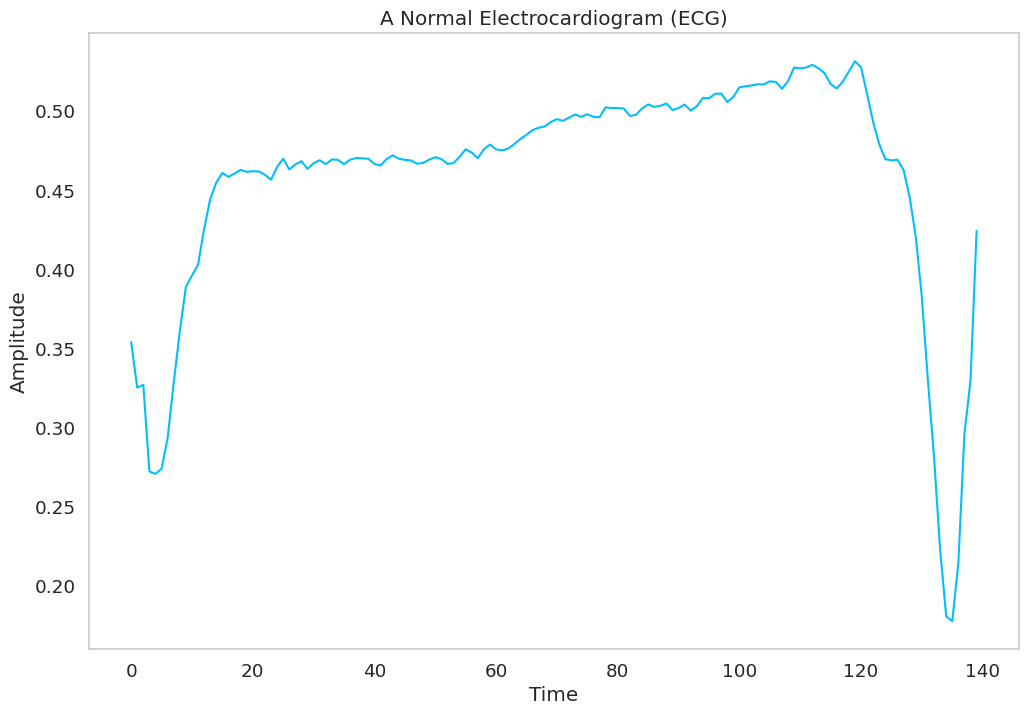

In [48]:
# Check the shape of normal_train_data to ensure data integrity
print("Shape of normal_train_data:", normal_train_data.shape)

# Verify indexing operation to prevent errors
if normal_train_data.shape[0] > 0:
    # Plot a sample Electrocardiogram (ECG) from normal_train_data
    # Displaying a representative sample helps visualize the data
    plt.plot(np.arange(140), normal_train_data[0])
    plt.title("A Normal Electrocardiogram (ECG)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid()  # Ensure grid lines are displayed
    plt.show()
else:
    # If normal_train_data is empty, prompt to check data loading and preprocessing
    print("No data in normal_train_data. Check data loading and preprocessing.")

The code generates a visualisation of a subset of abnormal Electrocardiogram (ECG) data from the training set. Grid lines are useful for enhancing clarity. The ECG plot is identified as anomalous, which aids in differentiating it from regular data. The plot illustrates the amplitude of the ECG over time, which facilitates the identification of anomalies.

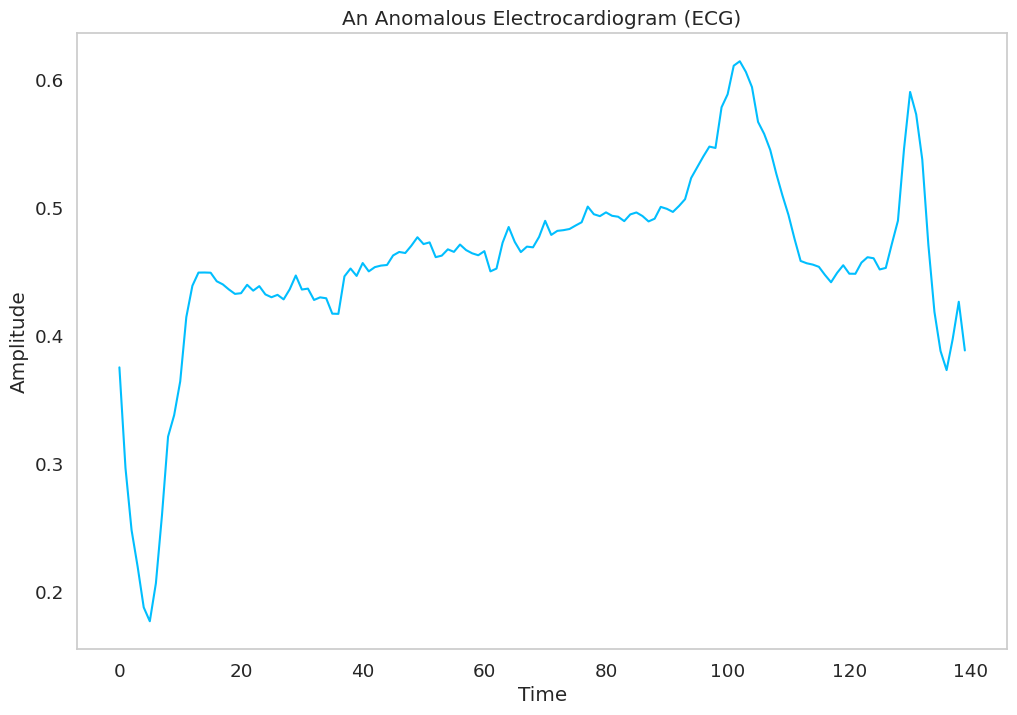

In [49]:
# Display grid lines for better visualization
plt.grid()

# Plot a sample Electrocardiogram (ECG) from anomalous_train_data
# Displaying a representative sample helps visualize anomalous data
plt.plot(np.arange(140), anomalous_train_data[0])

# Set title to indicate that the plotted ECG is anomalous
plt.title("An Anomalous Electrocardiogram (ECG)")

# Label the axes
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Show the plot
plt.show()

Network for Encoding:

The encoder network transforms the input data into a compact representation.
The structure consists of three compact layers that utilise ReLU activation functions.
The dense layers in the model effectively decrease the data's dimensionality, capturing the crucial features.
Dropout layers are included after each dense layer to mitigate overfitting. The dropout rate is set at 0.1.
The encoder network's final layer produces an encoded representation of the input data, consisting of 8 dimensions.
Network for Decoding:

The decoder network is responsible for reconstructing the original input data using the encoded representation provided by the encoder.
The architecture includes three densely connected layers with Rectified Linear Unit (ReLU) activation functions.
In order to prevent overfitting, dropout layers with a dropout rate of 0.1 are incorporated after each dense layer, mirroring the structure of the encoder.
The last layer of the decoder network employs a sigmoid activation function to reconstruct the input data, guaranteeing that the output values fall within the range of [0, 1].
The decoder network's output dimensionality is equal to the input data's dimensionality, which is 140 in this instance.
In general, the objective of this architecture is to acquire a condensed representation of the input data via the encoder and subsequently reconstruct the original data from this representation using the decoder. Dropout layers are incorporated to improve the model's generalisation capacity by mitigating overfitting.

In [50]:
# Define a custom anomaly detection model using TensorFlow and Keras
class AnomalyDetector(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()

        # Define the encoder network architecture
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),  # Encode input data into a dense representation
            layers.Dropout(0.1),  # Add dropout layer to prevent overfitting
            layers.Dense(16, activation="relu"),  # Further encode data
            layers.Dropout(0.1),  # Add dropout layer
            layers.Dense(8, activation="relu")])  # Final encoding layer

        # Define the decoder network architecture
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),  # Decode the dense representation
            layers.Dropout(0.1),  # Add dropout layer
            layers.Dense(32, activation="relu"),  # Further decode data
            layers.Dropout(0.1),  # Add dropout layer
            layers.Dense(140, activation="sigmoid")])  # Reconstruct input data

    # Define the forward pass of the model
    def call(self, x):
        # Encode input data using the encoder network
        encoded = self.encoder(x)
        # Decode the encoded data using the decoder network
        decoded = self.decoder(encoded)
        return decoded

# Instantiate an instance of the AnomalyDetector class
autoencoder = AnomalyDetector()

This code compiles an autoencoder model for anomaly detection. It utilises the Adamax optimizer and binary cross-entropy loss function. Adamax is selected for its ability to adapt the learning rate and its efficiency, while binary cross-entropy loss quantifies the discrepancy between the reconstructed data and the original input. This step ensures that the model is ready for training by setting up the optimisation and loss computation.

In [51]:
# Compile the autoencoder model with Adagrad optimizer and binary cross-entropy loss function
# Optimizer: Adamax optimizer, a variant of Adam, is chosen for its adaptive learning rate capabilities and efficiency.
# Loss function: Binary cross-entropy loss is used to measure the difference between the reconstructed data and the original input.
autoencoder.compile(optimizer=Adamax(), loss='BinaryCrossentropy')

This code trains an autoencoder model for the purpose of anomaly detection. The model's objective is to accurately reconstruct normal instances, so it utilises normal data for both input and target. The training process consists of 20 epochs, with each epoch comprising batches of 256 samples. Standard test data is used for validation, ensuring the model's performance on unseen data. Ensuring the shuffling of training data is crucial in order to prevent the model from memorising the data.

In [52]:
# Train the autoencoder model using the fit method
# Training data: normal_train_data is used both as input and target since the model aims to reconstruct normal data.
# Epochs: Training is performed over 20 epochs, iterating over the entire dataset 20 times.
# Batch size: Training data is divided into batches of size 256 for efficiency.
# Validation data: normal_test_data is used for validation during training to monitor model performance on unseen data.
# Shuffle: Training data is shuffled at the beginning of each epoch to prevent the model from memorizing the order of the data.
history = autoencoder.fit(
    normal_train_data,  # Input and target data for training
    normal_train_data,  # Target data for reconstruction
    epochs=20,  # Number of training epochs
    batch_size=256,  # Batch size for training
    validation_data=(normal_test_data, normal_test_data),  # Validation data
    shuffle=True  # Shuffle training data at the beginning of each epoch
)

Epoch 1/20
5/5 [==============================] - 2s 85ms/step - loss: 0.6929 - val_loss: 0.6924
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 0.6922 - val_loss: 0.6917
Epoch 3/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6916 - val_loss: 0.6910
Epoch 4/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6910 - val_loss: 0.6902
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 0.6903 - val_loss: 0.6895
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.6897 - val_loss: 0.6887
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.6890 - val_loss: 0.6880
Epoch 8/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6883 - val_loss: 0.6873
Epoch 9/20
5/5 [==============================] - 0s 19ms/step - loss: 0.6878 - val_loss: 0.6866
Epoch 10/20
5/5 [==============================] - 0s 19ms/step - loss: 0.6871 - val_loss: 0.6860
Epoch 11/20
5/5 [============

This code generates a visual representation of the loss incurred during the training and validation phases of an autoencoder model, plotted against the number of epochs. The training loss curve illustrates the model's fit to the training data at each epoch. The validation loss curve illustrates the model's performance on unseen data, providing a means to evaluate its ability to generalise.

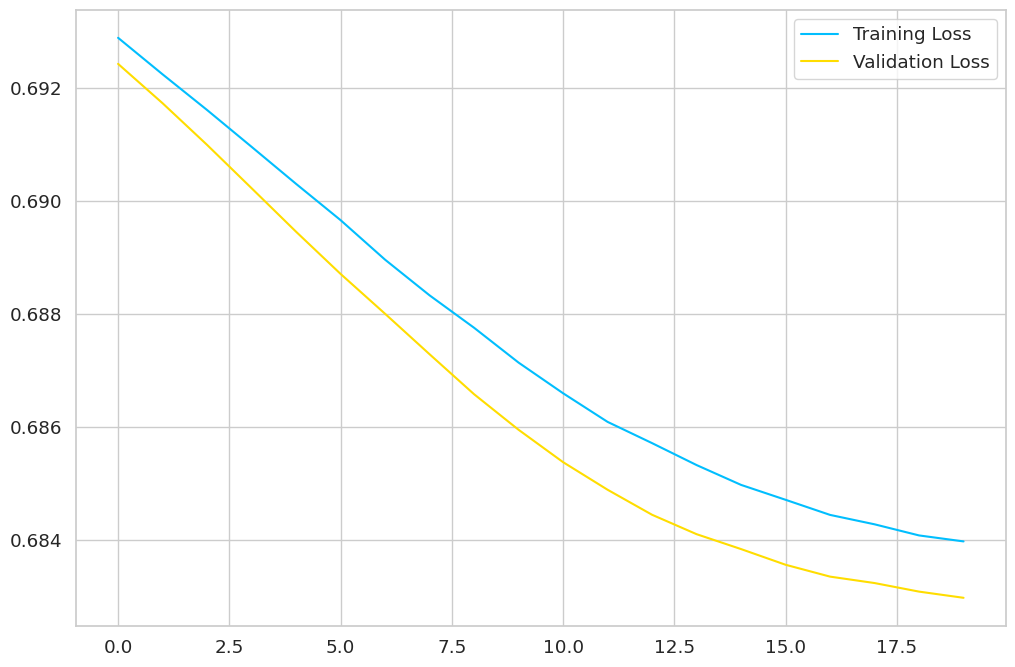

In [53]:
# Plot the training and validation loss over epochs
# Training Loss: Plot the loss values computed during training to monitor model performance.
# Validation Loss: Plot the loss values computed on the validation set to assess model generalization.
plt.plot(history.history["loss"], label="Training Loss")  # Plot training loss
plt.plot(history.history["val_loss"], label="Validation Loss")  # Plot validation loss
plt.legend()  # Add legend to the plot

The code acquires encoded and decoded representations of anomalous test data using an autoencoder model.
It verifies the accuracy of data arrays and their dimensions to ensure accurate visualisation.
When the data is deemed valid, it proceeds to display the original anomalous sample in blue, alongside the reconstructed sample in red.
Furthermore, it emphasises the reconstruction error between the original and reconstructed samples using a light coral fill.
The visualisation assists in qualitatively assessing the performance of the autoencoder model in reconstructing abnormal data.

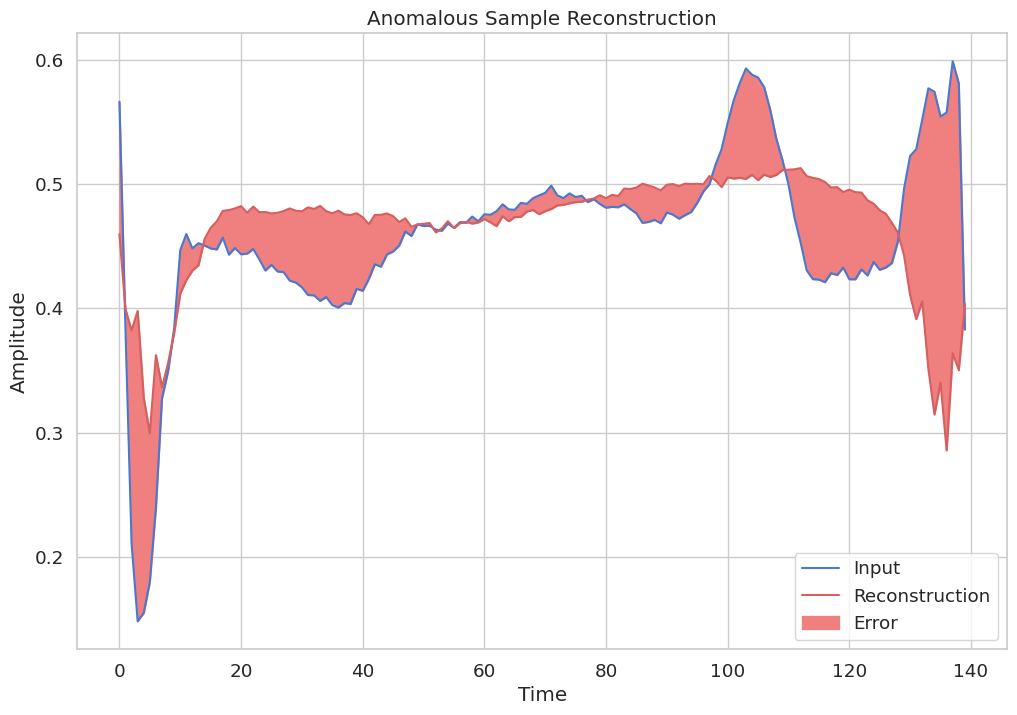

In [54]:
# Obtain the encoded and decoded images using the autoencoder model
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Check if the arrays are not empty and have valid dimensions
if len(anomalous_test_data) == 0 or len(decoded_imgs) == 0:
    print("Error: Empty arrays.")
elif anomalous_test_data.shape[0] != decoded_imgs.shape[0]:
    print("Error: Dimensions of anomalous_test_data and decoded_imgs do not match.")
else:
    # Plot the first sample along with its reconstruction
    plt.plot(anomalous_test_data[0],'b')  # Plot original anomalous sample in blue
    plt.plot(decoded_imgs[0],'r')  # Plot reconstructed sample in red
    plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )  # Highlight reconstruction error
    plt.legend(labels=["Input", "Reconstruction", "Error"])  # Add legend labels for clarity
    plt.xlabel("Time")  # Label x-axis as Time
    plt.ylabel("Amplitude")  # Label y-axis as Amplitude
    plt.title("Anomalous Sample Reconstruction")  # Add title to the plot
    plt.grid(True)  # Enable grid lines for better visualization
    plt.show()  # Display the plot

The code segment is designed to identify anomalies by comparing the reconstruction loss of normal training data. The autoencoder model is used to reconstruct the normal training data, and then the Mean Absolute Error (MAE) loss is computed between the original and reconstructed data. Next, it presents a histogram that visually represents the distribution of train loss values. This enables the detection of anomalies by identifying unusually high reconstruction errors.

40/40 [==============================] - 0s 1ms/step


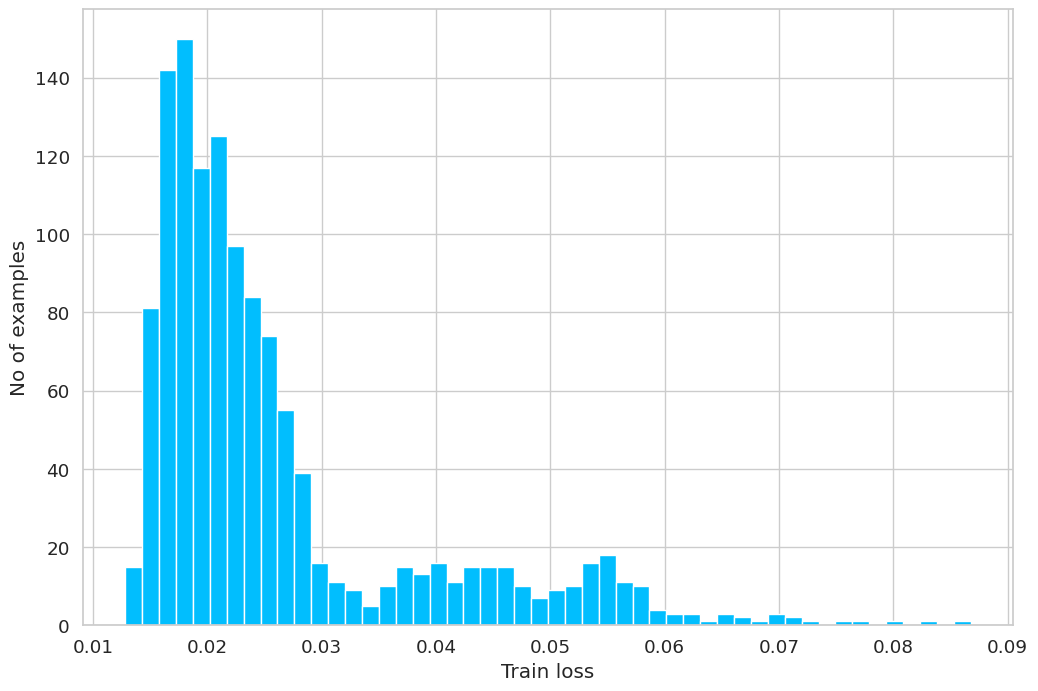

In [55]:
# Detect anomalies by comparing the reconstruction loss of normal training data
# Reconstruct normal training data using the autoencoder model
reconstructions = autoencoder.predict(normal_train_data)

# Compute the Mean Absolute Error (MAE) loss between original and reconstructed data
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

# Plot a histogram of the train loss values to visualize the distribution
plt.hist(train_loss, bins=50)  # Plotting the train loss distribution with 50 bins
plt.xlabel("Train loss")  # Label x-axis as Train loss
plt.ylabel("No of examples")  # Label y-axis as No of examples
plt.show()  # Display the histogram

This approach utilizes the Receiver Operating Characteristic (ROC) curve analysis to determine the optimal threshold. It specifically employs Youden's J statistic to maximize the balance between the True Positive Rate (TPR) and False Positive Rate (FPR).The ROC curve method offers a more balanced evaluation of the model's performance by considering both sensitivity and specificity, in contrast to the histogram method that solely relies on the distribution of reconstruction errors. The threshold is set to optimize the model's ability to distinguish between normal and anomalous data, leading to a stronger and more reliable anomaly detection threshold.

40/40 [==============================] - 0s 1ms/step


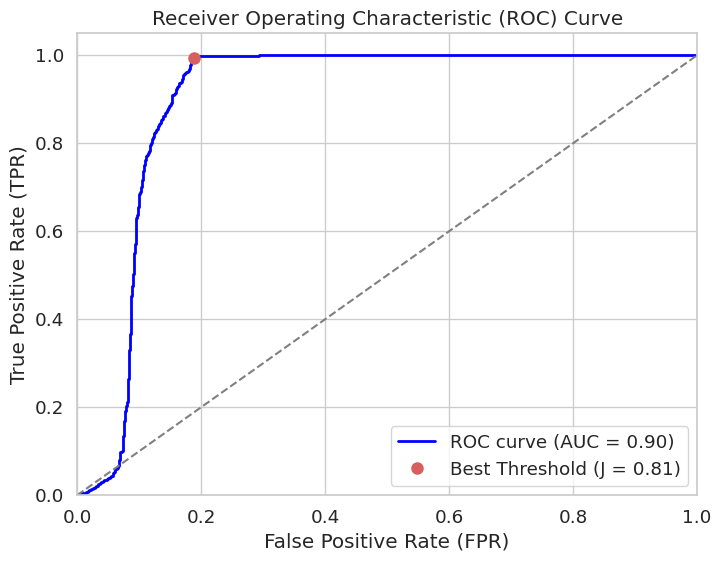

In [56]:
# Import necessary libraries for ROC curve analysis

# Obtain reconstructions for anomalous and normal data using the autoencoder model
reconstructions_anomalous = autoencoder.predict(anomalous_train_data)
reconstructions_normal = autoencoder.predict(normal_train_data)

# Calculate Mean Absolute Error (MAE) loss for anomalous and normal data
loss_anomalous = tf.keras.losses.mae(reconstructions_anomalous, anomalous_train_data)
loss_normal = tf.keras.losses.mae(reconstructions_normal, normal_train_data)

# Combine losses and create corresponding labels (1 for anomalous, 0 for normal)
loss = np.concatenate([loss_anomalous, loss_normal])
labels = np.concatenate([np.ones_like(loss_anomalous), np.zeros_like(loss_normal)])

# Compute the Receiver Operating Characteristic (ROC) curve
fpr, tpr, thresholds = roc_curve(labels, loss)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic for each threshold
J = tpr - fpr

# Find the threshold that maximizes Youden's J statistic
best_threshold_index = np.argmax(J)
best_threshold = thresholds[best_threshold_index]

# Assign the best threshold value to threshold_ae
threshold_ae = best_threshold

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot(fpr[best_threshold_index], tpr[best_threshold_index], 'ro', markersize=8, label='Best Threshold (J = %0.2f)' % J[best_threshold_index])
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

This code segment presents a visualisation of the distribution of Mean Absolute Error (MAE) loss values for the reconstructions of anomalous test data generated by an autoencoder model. A histogram is created to visually display the frequency of various loss values. An additional element is added to the plot - a vertical red dashed line that marks the threshold value utilised for anomaly detection. This visualisation aids in comprehending the distribution of reconstruction errors and their comparison to the selected anomaly detection threshold.

23/23 [==============================] - 0s 1ms/step


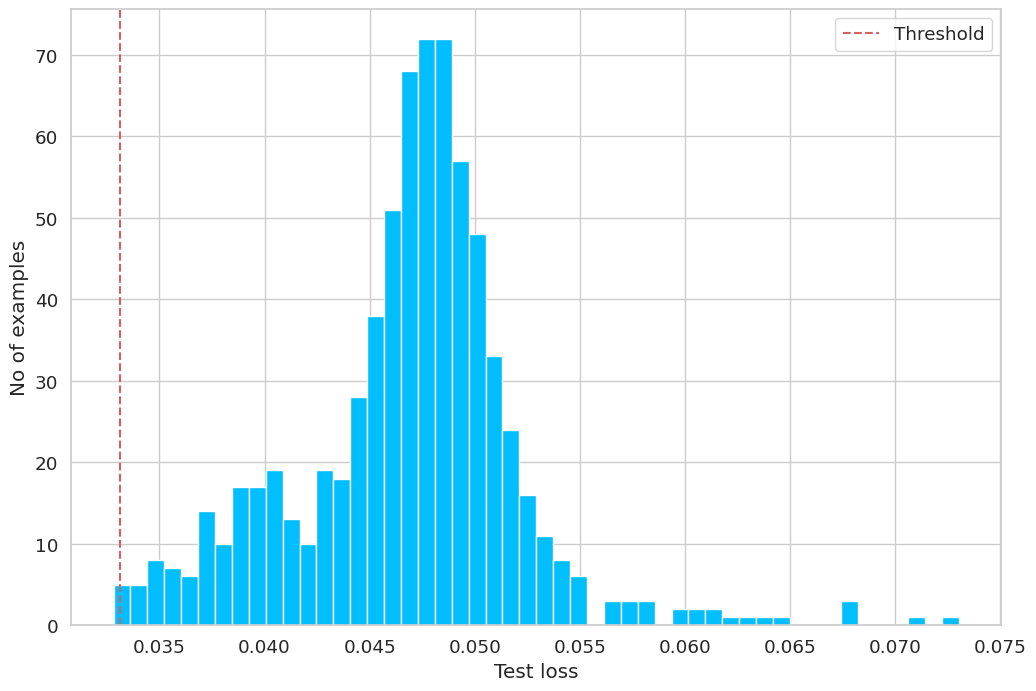

In [57]:
# Obtain reconstructions for anomalous test data using the autoencoder model
reconstructions = autoencoder.predict(anomalous_test_data)

# Calculate Mean Absolute Error (MAE) loss for anomalous test data
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

# Plot a histogram of the test loss values to visualize the distribution
plt.hist(test_loss, bins=50)  # Plotting the test loss distribution with 50 bins
plt.axvline(threshold_ae, c='r', linestyle='--', label='Threshold')  # Add vertical line at the threshold value in red
plt.xlabel("Test loss")  # Label x-axis as Test loss
plt.ylabel("No of examples")  # Label y-axis as No of examples
plt.legend()  # Display legend with threshold
plt.show()  # Display the histogram

The autoencoder model, input data, and a threshold are used to predict anomalies by analysing the reconstruction loss. The algorithm evaluates the reconstruction loss of the input data against a threshold and generates a boolean array that signifies anomalies (True) and normal instances (False).
The print_stats function accepts predicted anomalies and true labels as inputs and displays evaluation metrics such as Accuracy, Precision, and Recall scores. The performance of anomaly detection is assessed by comparing predicted anomalies with true labels.

In [58]:
def predict(model, data, threshold):
    """
    Predict anomalies based on reconstruction loss and a specified threshold.

    Args:
    - model: An autoencoder model used for reconstruction.
    - data: Input data to be reconstructed.
    - threshold: Threshold value for anomaly detection.

    Returns:
    - An array of boolean values indicating anomalies (True) and normal instances (False).
    """
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    """
    Print evaluation metrics based on predicted anomalies and true labels.

    Args:
    - predictions: Predicted anomalies (True) and normal instances (False).
    - labels: True labels indicating anomalies (True) and normal instances (False).

    Prints:
    - Accuracy, Precision, and Recall scores for the anomaly detection.
    """
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

This code segment performs anomaly detection on the test data using the trained autoencoder model and assesses its performance.

The predicted anomalies are stored in the preds variable, which is determined by comparing the reconstruction loss with a specified threshold.
The print_stats function calculates and displays metrics such as Accuracy, Precision, and Recall. These metrics are used to compare predicted anomalies with true labels.
One can evaluate the autoencoder's ability to detect anomalies in the test data.

In [59]:
# Predict anomalies using the autoencoder model and the calculated threshold
preds = predict(autoencoder, test_data, threshold_ae)

# Print evaluation metrics based on predicted anomalies and true labels
print_stats(preds, test_labels)
f1 = f1_score(preds, test_labels, average='weighted')
print('F1-Score',f1)

Accuracy = 0.916
Precision = 0.9952941176470588
Recall = 0.8041825095057035
F1-Score 0.9177220268291542


This code segment evaluates the performance of an anomaly detection model by analysing its predictions against the true labels.

The classification report includes Precision, Recall, and F1-score.
The confusion matrix is computed to display the number of True Positives, False Positives, True Negatives, and False Negatives.
The True Positive Rate (TPR) and False Positive Rate (FPR) are calculated using the confusion matrix in order to assess the performance of the model.
Lastly, the report containing the classification results and the True Positive Rate (TPR) and False Positive Rate (FPR) values are displayed for further analysis and interpretation.

In [60]:

# Calculate classification report based on true labels and predicted labels
report = classification_report(test_labels, preds)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
TP = conf_matrix[1, 1]  # Number of True Positives
FP = conf_matrix[0, 1]  # Number of False Positives
TN = conf_matrix[0, 0]  # Number of True Negatives
FN = conf_matrix[1, 0]  # Number of False Negatives

TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate

# Print classification report
print(report)

# Print True Positive Rate (TPR) and False Positive Rate (FPR)
print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)

              precision    recall  f1-score   support

       False       0.88      1.00      0.93       724
        True       1.00      0.80      0.89       526

    accuracy                           0.92      1250
   macro avg       0.94      0.90      0.91      1250
weighted avg       0.93      0.92      0.91      1250

True Positive Rate (TPR): 0.8041825095057035
False Positive Rate (FPR): 0.0027624309392265192


The purpose of saving the model to a file is to preserve the trained model's architecture, weights, and configuration for future use without needing to retrain it. Saving the model to a file allows us to easily reload and deploy the model for inference on new data or share it with others for evaluation or integration into applications. This ensures that the trained model can be reused efficiently without the need to retrain it every time it's needed, saving time and computational resources. Additionally, saving the model enables you to maintain a record of the trained model's performance and architecture for reproducibility and documentation purposes.

In [61]:
from tensorflow.keras.models import save_model

# Save the model to file
autoencoder.save('mymodel', save_format='tf')

 # Developing a GUI to stimulate Realtime ECG Anomaly detection.

**Note: Please follow the instructions provided in the note section after each step for hassle free user experience.**

Installing the Streamlit library in your Python environment

In [62]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


The code loads a pretrained autoencoder model used to predict anomalies in ECG data. The graphical user interface (GUI) enables users to upload a .arff file containing approximately 20 sets of ECG data points. Each row of data is processed sequentially. To simulate real-time processing, there's a 5-second delay between processing each row.

During processing, the application displays two ECG graphs: one representing a normal ECG signal in blue and the other representing the ECG signal currently being processed in red. Based on the model's output, the application indicates whether the current ECG signal is anomalous or not.

In [63]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from datetime import datetime

fs = 700  # Assuming a sampling frequency of 1000 Hz

# Load the trained LSTM model
model = tf.keras.models.load_model('/content/mymodel')

def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)


def parse_arff(arff_string):
    data_lines = arff_string.split("@data")[1].splitlines()
    data = []
    for line in data_lines:
        line = re.sub(r' +', ',', line)  # Replace consecutive spaces with commas
        line = line.strip().split(',')
        data.append(line)
    return pd.DataFrame(data)

threshold_str = '0.69'
threshold_float = float(threshold_str)

# Function to make predictions on single ECG data
def predict_ecg_class(ecg_data):
    try:
        ecg_sample = np.array(ecg_data)[:-1].astype(np.float32).reshape(1, -1)
        preds = predict(model, ecg_sample, threshold_float)
        return preds
    except Exception as e:
        st.error(f"Prediction error: {e}")

def plot_ecg(ecg_data):
    normal_values=[-2.0146349,-3.2352099,-3.9077729,-4.2799592,-3.8614212,-2.7448968,-1.6531768,-1.4342629,-0.85409171,-0.12429036,-0.20525656,-0.17898886,-0.16539256,-0.11430058,-0.12058269,0.026010539,-0.027696274,-0.14097046,-0.21830354,-0.24915005,-0.25576672,-0.34076341,-0.24307162,-0.31556986,-0.27343163,-0.32976372,-0.4356944,-0.5372366,-0.59449371,-0.61774979,-0.6580855,-0.60561479,-0.70106029,-0.71492057,-0.70813437,-0.81635319,-0.88268453,-0.72688735,-0.72670128,-0.72299491,-0.52307965,-0.49085929,-0.28319792,-0.28104357,-0.17987953,-0.098301179,-0.15532756,-0.066585313,-0.054767563,-0.054057739,0.061079137,0.063779961,0.043558406,0.072899633,-0.0075018824,0.013851908,-0.018913394,-0.092908194,0.0095594721,0.12141772,-0.013951107,-0.025362451,0.048980625,0.068499278,0.17247315,0.20577017,0.08701522,0.16705462,0.20767976,0.24789722,0.29887354,0.27691362,0.45393886,0.49478731,0.52697555,0.53221206,0.4897719,0.58262033,0.65972373,0.58256376,0.6027828,0.60823505,0.51182823,0.51346372,0.58263229,0.54453874,0.48042279,0.50886763,0.58275854,0.35995291,0.50659714,0.49605307,0.52536627,0.6060058,0.61306958,0.81110146,0.95592183,1.1866059,1.4415421,1.5835272,1.7938621,2.1094753,2.0586307,2.0337478,1.8259305,1.6282941,1.6425145,1.3713273,1.083284,0.83870516,0.53637474,0.13409333,-0.15393588,-0.19894149,-0.17256407,-0.31762534,-0.3136952,-0.25821554,-0.4415354,-0.30358261,-0.30534486,-0.37860908,-0.37740162,-0.33042167,-0.29791476,-0.23833905,-0.20042313,0.044195927,0.63078739,1.4685196,1.4926868,1.1398698,1.2521811,0.78591208,0.39364772,-0.18046529,-0.29458655,0.020224585,0.20908875,-1.1838593]
    ecg_values = [float(value) for value in ecg_data.values.tolist()[:-1]]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(ecg_values) + 1), ecg_values, linestyle='-',label='ECG Signal',color='red')
    plt.plot(range(1, len(normal_values) + 1), normal_values, linestyle='-',label='Normal Values',color='blue',alpha=0.4)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('ECG Signal with Normal Values Overlay')
    plt.ylim(-5, 5)  # Set y-axis limits from -5 to 5
    plt.grid(True)
    plt.legend()
    st.pyplot(plt)

def main():
    st.title("Real-Time ECG Classification")

    # Upload ARFF file containing ECG data
    ecg_data_file = st.file_uploader("Upload ARFF File", type=["arff"])

    if ecg_data_file is not None:
        # Read ARFF data
        arff_data = ecg_data_file.read().decode("utf-8")

        # Parse ARFF data
        ecg_data = parse_arff(arff_data)

        # Display the uploaded ECG data
        st.write("Uploaded ECG Data:")
        ecg_data=ecg_data.iloc[1:]
        st.write(ecg_data.iloc[:, :-1])


        # Real-time processing
        st.write("Real-Time Prediction:")
        for index, row in ecg_data.iterrows():
            st.write(f"-----------------------------------------------------------------------------------")
            st.write(f"Processing Row {index}")

            prediction = predict_ecg_class(row)
            #st.write("Predicted Class:", prediction)
            predicted_value = prediction[0].numpy()
            #st.write("Predicted Class:", predicted_value)
            if predicted_value:
               st.write("Prediction: Anomalous")
            else:
               st.write("Prediction: Normal")
            plot_ecg(row)  # Plot ECG graph
            currenttime =datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            st.write(f"Processed On:")
            st.write(currenttime)
            time.sleep(5)

if __name__ == "__main__":
    main()


Writing app.py


This command fetches and prints the public IPv4 address of the machine where the command is executed.

**Note: Please use this as the Tunnel Password for the website**

In [66]:
!wget -q -O - ipv4.icanhazip.com

34.23.138.112


The commands below leverage LocalTunnel to create a secure tunnel between your local computer and the internet. This tunnel enables you to share and access your locally hosted Streamlit application on port 8501 with other users over the internet. It also records any output or problems produced while the Streamlit program is running and saves them to a file for future use.

**Note: Please click on the link that is displayed after running the command and enter the above mentioned IP address as the tunnel password when prompted. You can use the provided GUI_Sample_TEST.arff file to upload. This file was created with less number of rows specifically to check the performace of the GUI.**

In [68]:
!npm install -g localtunnel
!streamlit run app.py &>/content/logs.txt &
!npx localtunnel --port 8501

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 1.142s
npx: installed 22 in 2.879s
your url is: https://empty-suits-share.loca.lt
^C


In the graphical user interface (GUI), the red line represents the graph of the currently processed ECG record, while the blue line depicts the normal ECG pattern expected for a healthy individual. This visual presentation facilitates easy comparison of the graphs, aiding in the identification of anomalies and enabling quick assessment of whether deviations from the normal pattern are present.

# Conclusion

In this Colab Notebook, we have successfully developed a deep learning-based system for real-time anomaly detection in ECG time series data, focusing on identifying abnormal heartbeats. The system utilizes a dataset consisting of 5,000 ECG sequences, each representing a single heartbeat from a patient diagnosed with congestive heart failure.


In order to solve class imbalance, we first preprocessed the ECG data by combining the training and test sets, resampling using techniques like SMOTE, and removing noise using a Butterworth band-pass filter. Preprocessing made sure that the data was balanced, clean, and prepared for analysis.


Following that, for anomaly detection and classification tasks, we explored and compared multiple deep learning models. In Model 1, dense layers, batch normalisation, dropout regularisation, and a sequential neural network architecture were used to analyse each data point individually at each time occurrence. Considering the data as a time series, Model 2 explored four versions of LSTM models that differed in terms of architecture, regularisation strategies, and noise injection. Model 3 performed multiclass classification using a convolutional neural network (CNN) architecture by utilising batch normalisation, dropout regularisation, and convolutional layers. Using an autoencoder architecture with dense layer encoder and decoder networks with dropout regularisation, Model 4 handled anomaly detection.


The models were trained, validated, and evaluated using appropriate metrics such as accuracy, precision, recall, F1-score, and confusion matrix. We also visualized the results using ROC curves, training and validation loss plots, and confusion matrices to gain insights into the models' performance.


In addition, we employed the Streamlit library to create a graphical user interface (GUI) that simulates real-time ECG abnormality detection. Users may upload an ECG data point .arff file to the GUI, and the pretrained autoencoder model resembles real-time processing by analysing each row sequentially with a 5-second delay. The programme shows two ECG graphs: one for the current ECG signal being analysed and the other for a typical ECG signal, along with an indication of whether the current signal is anomalous or not.


The system that was developed shows how well deep learning methods work for classifying and identifying abnormalities in ECG data. Preprocessing approaches, model architecture, and regularisation techniques together have demonstrated good results in detecting irregular heartbeats. For real-time ECG abnormality identification, the GUI offers a simple to use interface, making the system practical and approachable for medical practitioners.
To sum up, this notebook offers a comprehensive approach for applying deep learning to real-time anomaly identification in ECG time series data. The developed system has the potential to assist healthcare professionals in the early detection and diagnosis of heart-related conditions, ultimately improving patient care and outcomes. Further research and refinement of the models, as well as validation on larger and more diverse datasets, can enhance the system's robustness and generalizability.